Event Driven Simulation 

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


Scheduling CoMP
---------

In [3]:
import simpy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson

SCHEDULE_T=2 #Clock des Schedulers 



def df_to_ue_lists(df,cluster,thr):

    cluster=[19,20]
    df_filter=df.groupby('PCI Serving')
    ue_dict={}
    for i in cluster:
        counter=0
        ue_list=np.array([])
        df2=df_filter.get_group(i)
        for j in df2.index:
            ue_list=np.append(ue_list, ue(df.iloc[j]['JT_1 SINR [lin]'],df.iloc[j]['JT_2 SINR [lin]'],df.iloc[j]['PCI Serving'],df.iloc[j]['PCI Coord'],env,df.iloc[j]['usage'], thr,df.iloc[j]['id']))
        ue_dict[i]= ue_list
    return ue_dict

#function to monitor the level of the different queues
def monitor(queue,monitor): 
    monitor.update({env.now: queue.level})
    return monitor

def calculate_prb_number(users,max_prb):
    count=0
    count2=0
    for i in np.arange(len(users)):
        if(users[i].comp ==1):
            if(users[i].qos==0):
                count+=1
            if(users[i].qos==1):
                count+=4
            if(users[i].qos==2):
                count+=75
                
        elif(users[i].comp ==0):
            if(users[i].qos==0):
                count2+=1
            if(users[i].qos==1):
                count2+=4
            if(users[i].qos==2):
                count2+=75
    prb_number=round(count/count2*max_prb)
    return prb_number

def get_dataframe(users):
    df=pd.DataFrame()
    sinr=np.array([])
    sinr2=np.array([])
    tbs=np.array([])
    queue=np.array([])
    
    for i in np.arange(np.size(users)):
        sinr=np.append(sinr,users[i].sinr)
        sinr2=np.append(sinr,users[i].sinr2)
        tbs=np.append(sinr,users[i].tbs)
        queue=np.append(sinr,users[i].queue)
    df['sinr']=sinr
    df['sinr2']=sinr2
    df['tbs']=tbs
    df['queue']=queue
    return df

def calculate_tbs(sinr,sinr2):
    sinr=int(sinr)
    sinr2=int(sinr2)
    if(sinr>30 or sinr2>30):
        print('sinr out of range')
        tbs=30
        tbs2=30
    elif(sinr<-10):
        print('sinr out of range')
        tbs=-10
        tbs2=-10
    else:
        mapping=pd.read_csv('Data/sinr-tbs-mapping.csv')
        tbs=mapping.iloc[sinr].values[1]
        tbs2=mapping.iloc[sinr2].values[1]
    return tbs,tbs2

def central_scheduler(env, users, SCHEDULE_T,cluster, prb_number):
    
    counter=1 #counts the number of scheduling procedures
    alpha=-np.log10(0.01)/100
    print('new scheduling round:')
    while True: #größte Warteschlange wird auch bedient
        
        yield env.timeout(SCHEDULE_T) #for each ms the scheduling is active -> per TTI
        metric=np.array([]) 
        
        for i in np.arange(len(users)):
            users[i].mon= monitor(users[i].queue,users[i].mon)
    

        for i in np.arange(np.size(users)): 
            if(users[i].qos==1 or users[i].qos==2):
                metric=np.append(metric, (alpha*users[i].queue.level*(users[i].cp/users[i].mR)))  #list the metric of all UEs in the process 
                users[i].mR=(1-1/counter)*users[i].mR #Ratenanpassung für alle Nutzer    
            elif(users[i].qos==0):
                if(users[i].queue.level>0):
                    metric=np.append(metric,(users[i].cp/users[i].mR))
                    users[i].mR=(1-1/counter)*users[i].mR #Ratenanpassung für alle Nutzer
                elif(users[i].queue.level==0):
                    metric=np.append(metric,0)
                    users[i].mR=(1-1/counter)*users[i].mR #Ratenanpassung für alle Nutzer

        sched_user_list = (-metric).argsort() #sort UEs by metric that will be used for scheduling
        
        remaining_prb_list={}
        for i in cluster:
            remaining_prb_list[i]=prb_number
            
        k=0
        print('New scheduling round')
        free_res=1
        
        while(free_res==1):
            sched_user=sched_user_list[k]
            cell1=int(users[sched_user].cell1)
            cell2=int(users[sched_user].cell2)
            queue_size=users[sched_user].queue.level
            tbs=users[sched_user].tbs
            tbs2=users[sched_user].tbs2
            remaining_prbs=remaining_prb_list[cell1]
            remaining_prbs_c2=remaining_prb_list[cell2]
            #print('Resourcen:',remaining_prb_list[cell1])
            #print('Resourcen:',remaining_prb_list[cell2])
            #serving cell has no resources left -> no scheduling 
            if(remaining_prbs_c2==0):
                #print('keine Res mehr frei')
                continue
            #cell to coordinate with has no resources left -> without comp
            elif(remaining_prbs_c2==0):
                #print('ohne CoMP')
                sched_size=queue_size
                remaining_prb_list[cell1]=remaining_prbs-np.ceil(queue_size/tbs)
                
            elif((queue_size/tbs2)<=remaining_prbs and (queue_size/tbs2)<=remaining_prbs_c2 and queue_size>0):
            #comp can be used
                #print('mit CoMP')
                sched_size=queue_size
                remaining_prb_list[cell1]=remaining_prbs-np.ceil(queue_size/tbs2)
                remaining_prb_list[cell2]=remaining_prbs_c2-np.ceil(queue_size/tbs2)
            #one of the cells has not enough resources left 
            elif((queue_size/tbs2)>remaining_prbs or (queue_size/tbs2)>remaining_prbs_c2):
                #print('mit CoMP - v2')
                sched_size=min(remaining_prbs,remaining_prbs_c2)*tbs2
                remaining_prb_list[cell1]=remaining_prbs-np.ceil(sched_size/tbs2)
                remaining_prb_list[cell2]=remaining_prbs_c2-np.ceil(sched_size/tbs2)
                
            elif(queue_size==0):
                print('empty queue')
                break
            else:
                print('something went wrong')

            users[sched_user].mR=users[sched_user].mR+(1/counter)*sched_size
            users[sched_user].queue.get(sched_size)
            #print('Queue nachher:',users[sched_user].queue.level)
            k=k+1
            free_res=0
            for i in cluster:
                if(remaining_prb_list[i]!=0):
                    free_res=1
                    
        counter=counter+2
        
        


#scheduler takes packets from the queues according to the capacity of each user
def scheduler(env, users, SCHEDULE_T,cluster, prb_number, users2, prb_number2, sched_metric):
    
    counter=1 #counts the number of scheduling procedures
    alpha=-np.log10(0.01)/100
    bits1=0
    bits2=0
    while True: #größte Warteschlange wird auch bedient
        
        yield env.timeout(SCHEDULE_T) #for each ms the scheduling is active -> per TTI
        metric=np.array([]) 
        
        for i in np.arange(len(users)):
            users[i].mon= monitor(users[i].queue,users[i].mon)
        #users[0].mon= monitor(users[0].queue,users[0].mon)
        #users[10].mon= monitor(users[10].queue,users[10].mon)
        #users[120].mon= monitor(users[120].queue,users[120].mon)
        #users[100].mon= monitor(users[100].queue,users[100].mon)
        
        
        for i in np.arange(np.size(users)): 
            if(users[i].qos==1 or users[i].qos==2):
                metric=np.append(metric, (alpha*users[i].queue.level*(users[i].cp/users[i].mR)))  #list the metric of all UEs in the process 
                users[i].mR=(1-1/counter)*users[i].mR #Ratenanpassung für alle Nutzer    
            elif(users[i].qos==0):
                if(users[i].queue.level>0):
                    metric=np.append(metric,(users[i].cp/users[i].mR))
                    users[i].mR=(1-1/counter)*users[i].mR #Ratenanpassung für alle Nutzer
                elif(users[i].queue.level==0):
                    metric=np.append(metric,0)
                    users[i].mR=(1-1/counter)*users[i].mR #Ratenanpassung für alle Nutzer

        sched_user_list = (-metric).argsort() #sort UEs by metric that will be used for scheduling
        
        remaining_prbs=prb_number
        
        k=0
        print('New scheduling round')
        while(remaining_prbs>0):
            sched_user=sched_user_list[k]
            queue_size=users[sched_user].queue.level
            tbs=users[sched_user].tbs

            if((queue_size/tbs)<=remaining_prbs and queue_size>0):
                sched_size=queue_size
                remaining_prbs=remaining_prbs-np.ceil(queue_size/tbs)
            elif((queue_size/tbs)>remaining_prbs):
                sched_size=remaining_prbs*tbs
                remaining_prbs=remaining_prbs-np.ceil(sched_size/tbs)
                
            elif(queue_size==0):
                print('empty queue')
                break
            else:
                print('something went wrong')
          
            users[sched_user].mR=users[sched_user].mR+(1/counter)*sched_size
            users[sched_user].queue.get(sched_size)
            users[sched_user].bits+=sched_size
            k=k+1
            
            if(sched_user_list[k]==0 or sched_user_list[k]==1 or sched_user_list[k] ==2):
                print('ue-number sched1:', sched_user_list[k])
                print(users[sched_user].mR)
                print(counter)
        #TEST
        ############################
        metric=np.array([])
        for i in users2: 
            if(i.qos==1 or i.qos==2):
                metric=np.append(metric, (alpha*i.queue2.level*(i.cp/i.mR2)))  #list the metric of all UEs in the process 
                i.mR2=(1-1/counter)*i.mR2 #Ratenanpassung für alle Nutzer    
            elif(i.qos==0):
                if(i.queue2.level>0):
                    metric=np.append(metric,(i.cp/i.mR2))
                    i.mR2=(1-1/counter)*i.mR2 #Ratenanpassung für alle Nutzer
                elif(i.queue2.level==0):
                    metric=np.append(metric,0)
                    i.mR2=(1-1/counter)*i.mR2 #Ratenanpassung für alle Nutzer


        sched_user_list = (-metric).argsort() #sort UEs by metric that will be used for scheduling
        print(sched_user_list) 
        #print(sched_user_list)    
        #print(users[2].queue.level)
        remaining_prbs=prb_number2
        
        k=0
        #print('New scheduling round')
        while(remaining_prbs>0):
            sched_user=sched_user_list[k]
            queue_size=users2[sched_user].queue2.level
            tbs=users2[sched_user].tbs

            if((queue_size/tbs)<=remaining_prbs and queue_size>0):
                sched_size=queue_size
                remaining_prbs=remaining_prbs-np.ceil(queue_size/tbs)
            elif((queue_size/tbs)>remaining_prbs):
                sched_size=remaining_prbs*tbs
                remaining_prbs=remaining_prbs-np.ceil(sched_size/tbs)
                
            elif(queue_size==0):
                print('empty queue')
                break
            else:
                print('something went wrong')
            
            users2[sched_user].mR2=users2[sched_user].mR2+(1/counter)*sched_size
            users2[sched_user].queue2.get(sched_size)
            users2[sched_user].bits2+=sched_size
            
            if(sched_user_list[k]==0 or sched_user_list[k]==1 or sched_user_list[k] ==2):
                print('ue-number sched1:', sched_user_list[k])
                print(users2[sched_user].mR2)
                print(counter)
            
            k=k+1
        ###########################

        counter=counter+2
        

class ue:
    def __init__(self,sinr,sinr2,cell1,cell2,env,qos,thr,id):
        self.sinr=sinr
        self.sinr2=sinr2
        self.tbs,self.tbs2=calculate_tbs(sinr,sinr2)
        self.qos=qos
        self.cp=0.5*0.7*20000000*np.log2(1+np.power(10,sinr/10))/8000
        self.cp2=0.5*0.7*20000000*np.log2(1+np.power(10,sinr2/10))/8000 #division by 8000 to determine number of bits that can be transmitted per TTI (1ms)
        self.cell1=cell1
        self.cell2=cell2
        self.mR=0.1 #mittlere Rate
        self.mR2=0.1 #mittlere Rate
        self.queue=simpy.Container(env)
        self.queue2=simpy.Container(env)
        self.mon={}
        self.metric=self.sinr+self.queue.level
        self.metric2=self.sinr+self.queue.level
        self.gain=self.sinr2-self.sinr
        self.id=id
        self.bits=0
        self.bits2=0
        if(self.gain >thr):
            self.comp=np.array(1)
        else:
            self.comp=np.array(0) 
        
    def rt_user(self,env):
        on_off=1
        counter=0
        start=0
        while True:
            if(start==0):
                start=1
                yield env.timeout(random.randint(0,200))
            elif(on_off==1 and counter<3000):
                self.queue.put(160) #20 bytes
                self.queue2.put(160) #20 bytes
                mon= monitor(self.queue,self.mon)
                #yield env.timeout(poisson.rvs(6, 1))
                #print('On Phase')
                #print(self.queue.level)
                counter=counter+20
                #print(counter)
                yield env.timeout(20) #every 20ms new packet
            elif(on_off==0):
                on_off=1

                yield env.timeout(3000) #3s no packet to be sent
            elif(on_off==1 and counter>=3000):
                on_off=0
                counter=0
                #print('change from ON-OFF')
            
    def user_packets(self,env,packet_arr):
        while True:
            #print('o-user')
            self.queue.put(2000)
            self.queue2.put(2000) 
            #self.mon= monitor(self.queue,self.mon)
            yield env.timeout(poisson.rvs(packet_arr, 1))
            

    def streaming_user(self,env):
        while True:
            #print('o-user')
            self.queue.put(150) #1080p-> 1.5 Mbps (normal 1500)
            self.queue2.put(150) #1080p-> 1.5 Mbps 
            #self.mon= monitor(self.queue,self.mon)
            yield env.timeout(2)
    
    #Noch sehr vereinfacht!!!
    def sinr_variator(self,env):
        change=round(np.random.normal(0,0.5))
        if((self.sinr+change)>-10 and (self.sinr+change)<30): 
            self.sinr=self.sinr +change
            self.sinr2=self.sinr2+change 
        yield env.timeout(2000)


In [7]:
env=simpy.Environment()
#env = simpy.rt.RealtimeEnvironment(factor=1/10)

ue_list=np.array([])
ue_list2=np.array([])
#define UEs

    
max_prb=50
thr=6
cluster=[19,20]


x=np.append(np.ones(70)*19,np.ones(70)*20)
y=np.append(np.ones(70)*20,np.ones(70)*19)
sinr=np.random.randint(0,12,70*2)
sinr2=np.random.randint(2,16,70*2)
rt_nrt=np.array([])
rt_nrt=np.append(rt_nrt,np.ones(50)*0)
rt_nrt=np.append(rt_nrt,2)
rt_nrt=np.append(rt_nrt,2)
rt_nrt=np.append(rt_nrt,1)
rt_nrt=np.append(rt_nrt,np.ones(17))

rt_nrt=np.append(rt_nrt,np.ones(50)*0)
rt_nrt=np.append(rt_nrt,2)
rt_nrt=np.append(rt_nrt,2)
rt_nrt=np.append(rt_nrt,1)
rt_nrt=np.append(rt_nrt,np.ones(17))


df=pd.DataFrame()
df['PCI Serving']=x
df['PCI Coord']=y
df['JT_1 SINR [lin]']=sinr
df['JT_2 SINR [lin]']=sinr2
df['usage']=rt_nrt
df['id']=np.arange(0,140)
   
df['PCI Serving']=df['PCI Serving'].astype('int')
df['PCI Coord']=df['PCI Coord'].astype('int')

df['JT_1 SINR [lin]']=df['JT_1 SINR [lin]'].astype('int')
df['JT_2 SINR [lin]']=df['JT_2 SINR [lin]'].astype('int')


ue_dict=df_to_ue_lists(df,[19,20],6)
ue_all=np.array([])
for i in cluster:
    ue_all=np.append(ue_all,ue_dict[i])

prb_number_comp=calculate_prb_number(ue_all,max_prb)
prb_number_normal=max_prb-prb_number_comp


In [8]:
#Start processes
    
for i in cluster:
    ue_list=ue_dict[i]
    for j in np.arange(0,50):
        env.process(ue_list[j].user_packets(env,50))
        #env.process(ue_list[i].sinr_variator()) #movement
    env.process(ue_list[50].streaming_user(env))
    env.process(ue_list[51].streaming_user(env))
    #env.process(ue_list[100].sinr_variator()) #movement   
    for j in np.arange(52,70):
        env.process(ue_list[j].rt_user(env))
        #env.process(ue_list[i].sinr_variator()) #movement

        
ue_comp=np.array([]) #ues that use comp -> processed be central_scheduler
for i in cluster:
    ue_list=ue_dict[i]
    new_ue_list=np.array([])
    for j in ue_list:
        if(j.comp == 0):
            new_ue_list=np.append(new_ue_list,j)
        else:
            ue_comp=np.append(ue_comp,j)
    ue_dict[i]=new_ue_list #user without comp
    
env.process(central_scheduler(env,ue_comp,SCHEDULE_T,[19,20],prb_number_comp))

counter=0
for i in cluster:
    ue_list=ue_dict[i]
    ue_19=ue_all[counter*70:((counter+1)*70-1)]
    env.process(scheduler(env,ue_list,SCHEDULE_T,[19,20],prb_number_normal,ue_19,50,1))
env.run(until=5000)

new scheduling round:
New scheduling round
New scheduling round
[50 51 63  8 24 47 23  4 31  7 15  9 41  2 35 26 38 17  0 43 14 16 25 37
  5 42 49  1 30 46 36 21 20 40 12 45 34  3 10 11 29 44 28 22 13  6 19 48
 33 18 27 39 32 66 65 64 62 61 60 52 58 57 56 55 54 53 67 59 68]
New scheduling round
[ 0 27 28 29 30 31 32 33 35 36 37 26 38 40 41 42 43 44 45 46 47 48 49 39
 25 34 23  1  2  4  5  6  7  9 10 11 12  3 14 13 22 20 19 18 21 16 15 17
 24  8 50 51 63 61 66 65 64 62 60 53 58 57 56 55 54 52 67 59 68]
ue-number sched1: 0
2000.0
1
New scheduling round
New scheduling round
[34 28 29 30 31 32 33 51 35 36 37 38 39 40 41 42 43 44 45 46 47 48 26 49
 25 23  1  2  3  4  5  6  7 52  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 24 50 27  0  8 66 65 64 63 62 61 67 60 58 57 56 55 54 53 59 68]
New scheduling round
[25 26 29 30 31 32 33 51 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 24
 50 22  1  2  3  4  5  6  7 52  9 10 11 12 13 14 15 16 17 18 19 20 21 23
 28 27  0 34  8 66 65 64 63 62 61 67 60 58 5

<ipython-input-3-a00d895d6b32>:252: RuntimeWarning: divide by zero encountered in double_scalars
  metric=np.append(metric,(i.cp/i.mR2))
<ipython-input-3-a00d895d6b32>:248: RuntimeWarning: divide by zero encountered in double_scalars
  metric=np.append(metric, (alpha*i.queue2.level*(i.cp/i.mR2)))  #list the metric of all UEs in the process
<ipython-input-3-a00d895d6b32>:248: RuntimeWarning: invalid value encountered in double_scalars
  metric=np.append(metric, (alpha*i.queue2.level*(i.cp/i.mR2)))  #list the metric of all UEs in the process
<ipython-input-3-a00d895d6b32>:108: RuntimeWarning: divide by zero encountered in double_scalars
  metric=np.append(metric,(users[i].cp/users[i].mR))
<ipython-input-3-a00d895d6b32>:104: RuntimeWarning: divide by zero encountered in double_scalars
  metric=np.append(metric, (alpha*users[i].queue.level*(users[i].cp/users[i].mR)))  #list the metric of all UEs in the process
<ipython-input-3-a00d895d6b32>:104: RuntimeWarning: invalid value encountered in


ue-number sched1: 2
48.48546123179122
81
[65 63 50 51 39 32 48 46 18 28 49  0 30 27 33 11  6 19 29 13 22 45  3 44
 36 37 43 40 41 42 47 52 66 38 35 34 31  1  2  4  7  8  9 10 12 14  5 16
 26 25 24 15 68 23 21 20 17 53 54 55 56 58 59 60 61 62 64 67 57]
New scheduling round
[32 48 46 18 28 49  0 30 27 33 11  6 39 19 29 13 22 45  3 44 37 36 38 43
 41 42 47 50 51 52 63 65 66 40 35 34 31  1  2  4  7  8  9 10 12 14  5 16
 26 25 24 15 68 23 21 20 17 53 54 55 56 58 59 60 61 62 64 67 57]
New scheduling round
New scheduling round
ue-number sched1: 2
133.8228832713283
83
[52 50 51 23 48 46 18 28 49  0 30 27 33 11  6 39 19 29 32 13 22 45  3 44
 38 37 43 41 42 47 63 65 66 40 36 34  5  1  2  4 35  7  8  9 10 12 68 15
 16 17 20 21 24 31 26 25 14 64 62 61 57 59 58 56 55 54 53 60 67]
New scheduling round
[46 18 28 49  0 30 27 33 11  6 48 39 19 29 32 13 22 45  3 44 37 36 38 43
 41 42 47 50 51 52 63 65 66 40 35 34 31  1  2  4  7  8  9 10 12 14  5 16
 26 25 24 15 68 23 21 20 17 53 54 55 56 58 59 60 61 62

[36 40 46 19 45 10 12  3  6 48 44 39 11 13 33 20 27 28 18 29 32 22 34 53
 66 65 64 63 62 47 61 55 60 49 58 57 56 50 51 52 59 43  0 41  1  2  4  5
  7  8  9 14 15 16 17 21 23 24 25 26 30 31 67 35 37 38 42 68 54]
New scheduling round
New scheduling round
[61 52 50 51 46 19 45 10 12  3  6 48 44 39 11 13 33 20 40 27 28 18 29 32
 22 34 55 56 57 58 49 59 60 62 47 63 64 65 43 66 53 42  0 38  1  2  4  5
  7  8  9 14 15 16 17 21 23 24 25 26 30 31 67 35 36 37 41 68 54]
New scheduling round
ue-number sched1: 2
35.001536897013075
163
[45 10 12  3  6 48 44 19 39 11 13 33 20 40 27 28 18 29 32 22 34 55 66 43
 65 64 46 47 63 62 56 61 60 59 58 50 51 52 53 57 49 42  0 38  1  2  4  5
  7  8  9 14 15 16 17 21 23 24 25 26 30 31 67 35 36 37 41 68 54]
New scheduling round
New scheduling round
[55  8 50 47 51 12  3  6 48 44 10 19 39 11 13 33 20 40 27 28 18 29 32 22
 34 52 66 65 45 46 64 63 53 62 49 60 59 58 57 56 61 43  0 41  1  2  4  5
  7  9 14 15 16 17 21 23 24 25 26 30 31 67 35 36 37 38 42 68 54]
New sche

New scheduling round
New scheduling round
[58 62 50 51 44 33 27 13 39 48 32 34 29 11 19 30  6 18 22 28 42 43 66 45
 65 64 46 59 56 53 63 47 55 49 61 60 52 41 54 57  0 38  1  2  3  4  5  7
  8  9 10 12 14 15 16 17 20 21 23 24 25 26 31 67 35 36 37 40 68]
New scheduling round
[33 27 13 39 48 32 34 29 11 19 30  6 18 22 44 28 47 64 46 66 45 43 42 65
 63 61 51 52 41 53 54 55 56 62 57 58 59 60 49 50  0 38  1  2  3  4  5  7
  8  9 10 12 14 15 16 17 20 21 23 24 25 26 31 67 35 36 37 40 68]
New scheduling round
New scheduling round
[54 68 24 50 51 49 27 13 39 48 32 45 34 29 11 19 30  6 18 33 22 44 28 46
 47  5  4  3  2 52 53 66 62 55 65 64 63 56 57 58 59 60 61  1 40 42 14 15
 16 17 20 21 23 10 25 26  9 31  8 67 35 36 37 38  7 12 41 43  0]
New scheduling round
[49 27 13 39 48 32 45 34 29 11 19 30  6 18 33 22 44 28 65 64 66 43 42 46
 47 60 62 61 51 52 41 53 54 55 56 57 58 59 63 50  0 38  1  2  3  4  5  7
  8  9 10 12 14 15 16 17 20 21 23 24 25 26 31 67 35 36 37 40 68]
New scheduling round
New sched

  8  9 11 12 14 15 16 17 20 21 23 24 25 26 31 67 35 36 37 40 68]
New scheduling round
[45 39 19 48 29 27 33 34 18 32  6 22 13 10 30 28 44 49 66 43 47 42 46 64
 65 52 41 53 54 55 56 57 58 59 60 61 62 63 50 51  0 38  1  2  3  4  5  7
  8  9 11 12 14 15 16 17 20 21 23 24 25 26 31 67 35 36 37 40 68]
New scheduling round
New scheduling round
[66 56 57 59 50 51 19 48 29 27 33 34 18 39 32  6 22 13 10 30 28 44 41 42
 43 45 65 60 46 64 63 47 58 49 55 54 61 52 53 62  0 38  1  2  3  4  5  7
  8  9 11 12 14 15 16 17 20 21 23 24 25 26 31 67 35 36 37 40 68]
New scheduling round
[48 29 27 33 34 18 39 32  6 22 19 13 10 30 28 44 45 66 43 46 65 64 47 42
 63 61 51 52 41 62 53 54 55 56 57 58 59 60 49 50  0 38  1  2  3  4  5  7
  8  9 11 12 14 15 16 17 20 21 23 24 25 26 31 67 35 36 37 40 68]
New scheduling round
New scheduling round
[60 65 63 50 51 29 27 33 34 18 39 32  6 22 19 13 10 30 28 48 44 52 42 43
 45 66 57 46 56 64 55 62 47 54 49 53 59 61 41 58  0 38  1  2  3  4  5  7
  8  9 11 12 14 15 16 17 20 21

  8  9 10 12 14 15 16 17 20 21 23 25 26 30 31 67 35 36 37 40 68]
New scheduling round
[13  6 27 28 33 11 48 39 32 19 44 29 18 45 34 22 41 42 43 66 65 46 64 63
 47 58 59 50 51 52 40 53 54 55 56 61 57 60 62 49  0 37  1  2  3  4  5  7
  8  9 10 12 14 15 16 17 20 21 23 24 25 26 30 31 67 35 36 38 68]
New scheduling round
New scheduling round
[67 50 51 12  6 27 28 33 11 48 39 32 19 44 29 18 45 34 22 13 42 47 46 43
 49 53 54 55 56 57 58 59 60 61 62 63 64 65 66 52 41  0 38  1  2  3  4  5
  7  8  9 10 14 15 40 16 20 21 23 24 25 26 30 31 35 36 37 17 68]
New scheduling round
[ 6 27 28 33 11 48 39 32 19 44 29 18 45 34 22 13 41 42 43 66 65 46 64 63
 47 59 60 50 51 52 40 53 54 55 56 57 61 58 62 49  0 37  1  2  3  4  5  7
  8  9 10 12 14 15 16 17 20 21 23 24 25 26 30 31 67 35 36 38 68]
New scheduling round
New scheduling round
[50 51  1 27 28 33 11 48 39 32 19 44 29 18 45 34 22 13  6 42 43 66 65 46
 47 64 63 60 62 61 52 53 41 54 55 56 57 58 59 49  0 38  2  3  4  5  7  8
  9 10 12 14 15 16 17 20 21 23

New scheduling round
[46 39 28 33 27 13  6 10 19 34 32 29 18  3 45 22 44 48 42 43 66 65 47 64
 49 60 51 52 53 41 54 55 56 57 63 58 59 62 61 50  0 38  1  2  4  5  7  8
  9 11 12 14 15 16 17 20 21 23 24 25 26 30 31 67 35 36 37 40 68]
New scheduling round
New scheduling round
[61 52 50 51 28 33 27 13  6 10 19 34 32 29 39 18  3 45 22 44 48 42 43 66
 46 47 65 58 64 63 62 53 41 54 55 56 57 60 59 49  0 38  1  2  4  5  7  8
  9 11 12 14 15 16 17 20 21 23 24 25 26 30 31 67 35 36 37 40 68]
New scheduling round
[33 27 13  6 10 19 34 32 29 39 18  3 45 28 22 44 48 65 46 66 43 42 47 49
 62 63 52 53 41 54 55 56 57 58 59 64 60 61 50 51  0 38  1  2  4  5  7  8
  9 11 12 14 15 16 17 20 21 23 24 25 26 30 31 67 35 36 37 40 68]
New scheduling round
New scheduling round
[55 50 31 51 49 27 13  6 10 19 34 32 29 39 18 33  3 45 28 22 44 48 46 43
 42 47 53 54 56 57 58 59 60 61 62 63 64 65 66 52 41  0 38  1  2  4  5  7
  8  9 11 12 14 15 40 16 20 21 23 24 25 26 30 67 35 36 37 17 68]
New scheduling round
[49 27 13

 20 21 11 23 24 25 26 43  9 30 31  7 67 35 36 37 38 40 14  8  0]
New scheduling round
[48 32 39 28 10 19 22 18 27 34 13 45 33  6 29 44 41 42 43 66 46 65 61 47
 64 63 50 62 51 52 40 60 53 54 55 56 57 58 59 49  0 37  1  2  3  4  5  7
  8  9 11 12 14 15 16 17 20 21 23 24 25 26 30 31 67 35 36 38 68]
New scheduling round
New scheduling round
[53 64 50 51 32 39 28 10 19 22 18 27 34 13 45 33  6 29 48 44 43 42 46 41
 65 66 59 60 63 62 52 40 54 55 56 57 58 61 47 49  0 37  1  2  3  4  5  7
  8  9 11 12 14 15 16 17 20 21 23 24 25 26 30 31 67 35 36 38 68]
New scheduling round
[39 28 10 19 22 18 27 34 13 45 33 32  6 29 48 44 43 49 46 66 41 47 42 63
 64 52 40 53 54 55 56 57 58 65 59 60 61 62 50 51  0 37  1  2  3  4  5  7
  8  9 11 12 14 15 16 17 20 21 23 24 25 26 30 31 67 35 36 38 68]
New scheduling round
New scheduling round
[66 56 57 59 50  9 35 51 28 10 19 22 18 27 34 13 45 33 32  6 29 39 48 44
 46 47 43 42 53 52 54 55 58 60 61 62 63 64 65 49 41  0 38  1  2  3  4  5
  7  8 11 12 14 15 40 16 20 21

New scheduling round
New scheduling round
[50 51 39 45  6 27 34 48 32  3 33 11 28 18 13 44 19 29 22 66 42 46 47 65
 43 62 63 52 53 41 54 55 56 57 58 59 60 61 49 64  0 38  1  2  4  5  7  8
  9 10 12 14 15 16 17 20 21 23 24 25 26 30 31 67 35 36 37 40 68]
New scheduling round
[45  6 27 34 48 32  3 33 11 28 39 18 13 44 19 29 22 42 43 66 65 64 46 47
 63 62 60 59 50 51 52 53 41 54 55 56 57 58 61 49  0 38  1  2  4  5  7  8
  9 10 12 14 15 16 17 20 21 23 24 25 26 30 31 67 35 36 37 40 68]
New scheduling round
New scheduling round
[67 50  4 51 14 25  6 27 34 48 32  3 33 11 28 39 18 13 44 19 29 22 45 49
 46 47 55 53 54 56 57 58 59 60 61 62 63 64 65 66 52 43  0 41  1  2  5  7
  8  9 10 12 15 16 17 20 21 23 24 26 30 31 35 36 37 38 40 42 68]
New scheduling round
[14 25  6 27 34 48 32  3 33 11 28 39 18 13 44 19 29 22 45 49 43 47 50 46
 54 52 53 55 56 57 58 59 60 61 62 63 64 65 66 51 42  0 40  1  2  4  5  7
  8  9 10 12 15 16 41 17 21 23 24 26 30 31 67 35 36 37 38 20 68]
New scheduling round
New sched

New scheduling round
[22  6 32 33 13 18 11 29 27 19 39 48 10 28 44 34 45 42 43 66 65 46 47 64
 63 59 51 62 52 53 41 61 54 55 56 57 60 58 50 49  0 38  1  2  3  4  5  7
  8  9 12 14 15 16 17 20 21 23 24 25 26 30 31 67 35 36 37 40 68]
New scheduling round
New scheduling round
[53 64 50 31 41 17 51 30  6 32 33 13 18 11 29 27 19 39 48 10 28 44 34 22
 45 52 66 65 46 47 63 62 61 59 58 57 56 49 55 43 60 54  0 40  1  2  3  4
  5  7  8  9 12 14 15 16 20 21 23 24 25 26 67 35 36 37 38 42 68]
New scheduling round
[17 51 30  6 32 33 13 18 11 29 27 19 39 48 10 28 44 34 22 45 50 47 46 49
 43 54 53 55 56 57 58 59 60 61 62 63 64 65 66 52 42  0 40  1  2  3  4  5
  7  8  9 12 14 15 41 16 21 23 24 25 26 31 67 35 36 37 38 20 68]
New scheduling round
New scheduling round
[66 56 57 59 50 15 51  1 30  6 32 33 13 18 11 29 27 19 39 48 10 28 44 34
 22 45 47 46 49 55 53 54 43 58 60 61 62 63 64 65 52 42  0 40  2  3  4  5
  7  8  9 12 14 16 17 20 21 23 24 25 26 31 67 35 36 37 38 41 68]
ue-number sched1: 1
40.8116597

 12 14 15 16 17 20 40 21 24 25 26 30 31  4  3 67 35 36  5 23 68]
ue-number sched1: 0
42.991447641354256
771
New scheduling round
[32 34 39 27 22 33 18 48 19 28  6 45 13 44 29 66 49 46 47 42 41 43 64 65
 40 52 53 54 55 56 57 58 59 60 61 62 63 50 51  0 37  1  2  3  4  5  7  8
  9 10 11 12 14 38 15 17 20 21 23 24 25 26 30 31 67 35 36 16 68]
New scheduling round
New scheduling round
[58 62 50 51 34 39 27 22 33 18 48 19 28  6 45 32 13 44 29 41 42 43 61 60
 46 56 59 49 63 66 65 40 64 52 53 54 55 57 47  0 37  1  2  3  4  5  7  8
  9 10 11 12 14 38 15 17 20 21 23 24 25 26 30 31 67 35 36 16 68]
New scheduling round
[39 27 22 33 18 48 19 28  6 45 32 13 44 34 29 41 42 43 66 65 46 47 64 61
 50 51 40 62 52 53 54 55 56 57 58 59 60 49 63  0 37  1  2  3  4  5  7  8
  9 10 11 12 14 38 15 17 20 21 23 24 25 26 30 31 67 35 36 16 68]
New scheduling round
New scheduling round
[54 68  8 50 24  9 51 11 27 22 33 18 48 19 28  6 45 32 13 39 44 34 29 20
  4 49  3  2 52 53  1 55 56 57 58 59 60 61 62 63 64 65 66 47

  7  8  9 12 14 15 16 17 20 21 23 24 25 26 30 31 67 35 36 41 68]
New scheduling round
[40 33 18 39 27 32 13  3 45 11 34 10 48 28 44  6 29 19 22 60 42 43 66 46
 65 64 47 50 49 51 52 53 62 55 56 57 58 61 59 63 54  0 38  1  2  4  5  7
  8  9 12 14 15 16 41 17 21 23 24 25 26 30 31 67 35 36 37 20 68]
New scheduling round
New scheduling round
ue-number sched1: 0
9.622759785120177
849
[67 50 51 18 39 27 32 13  3 45 11 33 34 10 48 28 44  6 29 19 22 46 43 49
 47 54 53 55 56 57 58 59 60 61 62 63 64 65 66 52 42  0 40  1  2  4  5  7
  8  9 12 14 15 16 41 17 21 23 24 25 26 30 31 35 36 37 38 20 68]
New scheduling round
[39 27 32 13  3 45 11 33 18 34 10 48 28 44  6 29 19 22 47 43 42 49 46 50
 54 52 53 55 56 57 58 59 60 61 62 63 64 65 66 51 41  0 38  1  2  4  5  7
  8  9 12 14 15 16 40 17 21 23 24 25 26 30 31 67 35 36 37 20 68]
New scheduling round
New scheduling round
[50  2 51 27 32 13  3 45 11 33 18 34 10 48 39 28 44  6 29 19 22 47 46 49
 43 55 53 54 56 57 58 59 60 61 62 63 64 65 66 52 42  0 40  1 

  7  8  9 12 14 15 40 16 20 21 23 24 25 26 30 31 35 36 37 17 68]
New scheduling round
[33 34  6 48 39 13 18 32 27 28 10 11 22 19 44 29 45 57 42 43 66 64 46 47
 61 60 65 49 50 51 63 52 53 41 59 54 55 56 58 62  0 38  1  2  3  4  5  7
  8  9 12 14 15 16 17 20 21 23 24 25 26 30 31 67 35 36 37 40 68]
New scheduling round
New scheduling round
ue-number sched1: 2
65.1535107596895
931
[50 51 34  6 48 39 13 18 32 27 28 10 11 22 33 19 44 29 45 55 42 43 61 60
 46 47 59 58 66 49 65 64 62 52 53 41 57 54 56 63  0 38  1  2  3  4  5  7
  8  9 12 14 15 16 17 20 21 23 24 25 26 30 31 67 35 36 37 40 68]
New scheduling round
[ 6 48 39 13 18 32 27 28 10 11 22 33 19 44 29 34 45 42 43 66 65 46 47 64
 63 58 59 50 51 61 52 53 41 60 54 55 56 57 49 62  0 38  1  2  3  4  5  7
  8  9 12 14 15 16 17 20 21 23 24 25 26 30 31 67 35 36 37 40 68]
New scheduling round
New scheduling round
ue-number sched1: 2
10.279373188586524
933
[58 62 50 51 43 48 39 13 18 32 27 28 10 11 22 33 19  6 44 29 34 45 42 66
 65 64 46 47 54 61 

New scheduling round
New scheduling round
ue-number sched1: 0
145.1681039075022
1011
[50  7 51 25 27 18 32 33 39  3 44 29  6 11 19 28 34 45 13 22 48 47 46 43
 49 54 53 55 56 57 58 59 60 61 62 63 64 65 66 52 42  0 40  1  2  4  5  8
  9 10 12 14 15 16 41 17 21 23 24 26 30 31 67 35 36 37 38 20 68]
New scheduling round
[25 27 18 32 33 39  3 44 29  6 11 19 28 34 45 13 22 48 47 49 46 43 42 50
 53 52 54 55 56 57 58 59 60 61 62 63 64 65 66 51 41  0 38  1  2  4  5  7
  8  9 10 12 14 15 40 16 20 21 23 24 26 30 31 67 35 36 37 17 68]
New scheduling round
New scheduling round
[58 62 50 51 46 18 32 33 39  3 44 29  6 11 19 28 34 27 45 13 22 48 42 43
 66 65 64 63 47 55 54 57 49 60 59 52 53 41 61 56  0 38  1  2  4  5  7  8
  9 10 12 14 15 16 17 20 21 23 24 25 26 30 31 67 35 36 37 40 68]
New scheduling round
[46 18 32 33 39  3 44 29  6 11 19 28 34 27 45 13 22 48 42 43 66 65 64 63
 47 62 60 50 51 52 53 41 61 54 55 56 57 58 59 49  0 38  1  2  4  5  7  8
  9 10 12 14 15 16 17 20 21 23 24 25 26 30 31 67 35 

  8  9 10 12 14 15 16 17 20 21 23 24 25 26 30 31 67 35 36 38 68]
New scheduling round
New scheduling round
[53 64 50 51 27 39  6 13 22 19 33 44 28 29 18 32 11 48 34 45 41 42 43 46
 66 47 58 65 63 62 52 40 61 54 55 56 60 57 59 49  0 37  1  2  3  4  5  7
  8  9 10 12 14 15 16 17 20 21 23 24 25 26 30 31 67 35 36 38 68]
New scheduling round
[39  6 13 22 19 33 44 28 29 18 32 27 11 48 34 45 49 43 42 47 41 46 50 62
 51 52 40 53 54 55 56 65 57 58 59 60 61 64 63 66  0 37  1  2  3  4  5  7
  8  9 10 12 14 15 16 17 20 21 23 24 25 26 30 31 67 35 36 38 68]
New scheduling round
New scheduling round
[66 56 57 59 50 23 51  6 13 22 19 33 44 28 29 18 32 27 11 39 48 34 45 42
 43 65 64 63 46 47 52 61 60 49 58 55 54 53 41 62  0 38  1  2  3  4  5  7
  8  9 10 12 14 15 16 17 20 21 24 25 26 30 31 67 35 36 37 40 68]
New scheduling round
[13 22 19  6 33 44 28 29 18 32 27 11 39 48 34 45 41 42 43 66 65 64 46 63
 62 61 58 49 50 60 51 52 40 59 53 54 55 56 57 47  0 37  1  2  3  4  5  7
  8  9 10 12 14 15 16 17 20 21

New scheduling round
[27 18 48 39 19 22 34 44 13 45 29 33 11 32 28  6  3 10 46 43 42 49 47 50
 54 52 53 55 56 57 58 59 60 61 62 63 64 65 66 51 41  0 38  1  2  4  5  7
  8  9 12 14 15 16 40 17 21 23 24 25 26 30 31 67 35 36 37 20 68]
New scheduling round
New scheduling round
[53 64 50 51 36 18 48 39 19 22 34 44 13 45 29 33 11 32 27 28  6  3 10 47
 46 43 54 52 55 56 57 58 59 60 61 62 63 65 66 49 42  0 40  1  2  4  5  7
  8  9 12 14 15 16 41 17 21 23 24 25 26 30 31 67 35 37 38 20 68]
New scheduling round
[36 18 48 39 19 22 34 44 13 45 29 33 11 32 27 28  6  3 10 46 43 49 47 50
 54 52 53 55 56 57 58 59 60 61 62 63 64 65 66 51 42  0 40  1  2  4  5  7
  8  9 12 14 15 16 41 17 21 23 24 25 26 30 31 67 35 37 38 20 68]
New scheduling round
New scheduling round
[66 56 57 59 50 51 48 39 19 22 34 44 13 45 29 33 11 32 18 27 28  6  3 10
 47 46 43 42 54 52 53 55 58 60 61 62 63 64 65 49 41  0 38  1  2  4  5  7
  8  9 12 14 15 16 40 17 21 23 24 25 26 30 31 67 35 36 37 20 68]
New scheduling round
[39 19 22

New scheduling round
[30 39 22 18 10  3 19 48 32 11 27 34  6 29 28 33 13 44 45 47 46 43 49 50
 54 52 53 55 56 57 58 59 60 61 62 63 64 65 66 51 42  0 40  1  2  4  5  7
  8  9 12 14 15 16 41 17 21 23 24 25 26 31 67 35 36 37 38 20 68]
New scheduling round
New scheduling round
[60 65 63 50 51 26 22 18 10  3 19 39 48 32 11 27 34  6 29 28 33 13 44 45
 49 47 46 43 54 53 55 56 57 58 59 61 62 64 66 52 42  0 40  1  2  4  5  7
  8  9 12 14 15 16 41 17 21 23 24 25 30 31 67 35 36 37 38 20 68]
New scheduling round
[18 10  3 19 39 48 32 11 22 27 34  6 29 28 33 13 44 45 46 47 43 42 49 50
 54 52 53 55 56 57 58 59 60 61 62 63 64 65 66 51 41  0 38  1  2  4  5  7
  8  9 12 14 15 16 40 17 21 23 24 25 26 30 31 67 35 36 37 20 68]
New scheduling round
New scheduling round
[52 61 50 24  7 51 43  0 21 10  3 19 39 48 32 11 22 27 34  6 29 28 33 13
 18 44 45 17 49  5  4  2 53 54 55 57 58 59 60  1 62 63 64 65 66 56 47  8
 42 20 16 15 23 14 25 26 30 46 31 67 35 36 37 38  9 40 41 12 68]
New scheduling round
[ 7 51 43

New scheduling round
[60 65 63 50 51 17 21 29 33 19 18 13 27 10  6 44 45 39 48 32 28 22 34 47
 46 43 42 53 52 54 55 56 57 58 59 61 62 64 66 49 41  0 38  1  2  3  4  5
  7  8  9 11 12 14 40 15 20 23 24 25 26 30 31 67 35 36 37 16 68]
New scheduling round
ue-number sched1: 1
16.677314220262428
1341
[21 29 33 19 18 13 27 10  6 44 45 39 48 32 28 22 34 42 43 66 65 64 46 47
 63 62 57 50 51 61 52 41 60 53 54 55 56 59 58 49  0 38  1  2  3  4  5  7
  8  9 11 12 14 15 16 17 20 23 24 25 26 30 31 67 35 36 37 40 68]
New scheduling round
New scheduling round
ue-number sched1: 0
38.22449939868473
1343
[52 61 50 51 33 19 18 13 27 10  6 44 45 39 48 29 32 28 22 34 41 42 43 66
 65 64 46 56 57 49 62 60 59 40 58 53 54 55 63 47  0 37  1  2  3  4  5  7
  8  9 11 12 14 15 16 17 20 21 23 24 25 26 30 31 67 35 36 38 68]
New scheduling round
[19 18 13 27 10  6 44 45 39 33 48 29 32 28 22 34 41 42 43 66 65 46 64 47
 59 50 51 52 40 63 53 54 55 56 62 57 58 61 60 49  0 37  1  2  3  4  5  7
  8  9 11 12 14 15 16 17 20 2

New scheduling round
[67 50 51 30  6 10 27 19 13 29 39 33 32 18 28 44 48 34 22 45 46 43 42 47
 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 49 41  0 38  1  2  3  4  5
  7  8  9 11 12 14 40 15 17 20 21 23 24 25 26 31 35 36 37 16 68]
New scheduling round
[ 6 10 27 19 13 29 39 33 32 18 28 44 48 34 22 45 47 65 46 43 42 41 66 49
 61 51 52 40 53 54 55 56 64 57 58 63 59 60 62 50  0 37  1  2  3  4  5  7
  8  9 11 12 14 15 16 17 20 21 23 24 25 26 30 31 67 35 36 38 68]
New scheduling round
New scheduling round
[50 23 35 38 51 10 27 19 13 29 39 33 32 18 28 44 48  6 34 22 45 47 49 43
 46 52 54 55 56 57 58 59 60 61 62 63 64 65 66 53 42  0 40  1  2  3  4  5
  7  8  9 11 12 14 41 15 17 20 21 24 25 26 30 31 67 36 37 16 68]
New scheduling round
[51 38 10 27 19 13 29 39 33 32 18 28 44 48  6 34 22 45 47 46 42 66 41 65
 43 60 61 64 52 63 53 54 55 56 62 57 58 59 49 50  0 37  1  2  3  4  5  7
  8  9 11 12 14 15 16 17 20 21 23 24 25 26 30 31 67 35 36 40 68]
New scheduling round
New scheduling round
[58 62 50

New scheduling round
New scheduling round
[55 50 51 42  6 33 18 44 39 27 22 32 45 19 48 34 28 13 11 29 41 66 43 65
 64 63 62 46 56 49 60 59 58 52 40 53 54 57 61 47  0 37  1  2  3  4  5  7
  8  9 10 12 14 15 16 17 20 21 23 24 25 26 30 31 67 35 36 38 68]
New scheduling round
[33  6 18 44 39 27 22 32 45 19 48 34 28 13 11 29 41 42 43 66 65 64 63 46
 62 47 58 50 61 51 52 40 60 53 54 55 56 57 59 49  0 37  1  2  3  4  5  7
  8  9 10 12 14 15 16 17 20 21 23 24 25 26 30 31 67 35 36 38 68]
New scheduling round
New scheduling round
ue-number sched1: 0
69.93411814826445
1487
[50 51  1 12  6 18 44 39 27 22 32 45 19 48 34 33 28 13 11 29 43 42 47 49
 46 54 53 55 56 57 58 59 60 61 62 63 64 65 66 52 41  0 38  2  3  4  5  7
  8  9 10 14 15 16 40 17 21 23 24 25 26 30 31 67 35 36 37 20 68]
ue-number sched1: 1
40.405082342270305
1487
New scheduling round
[12  6 18 44 39 27 22 32 45 19 48 34 33 28 13 11 29 42 43 66 65 64 46 47
 63 58 59 51 62 52 53 41 61 54 55 56 57 60 49 50  0 38  1  2  3  4  5  7
  8  9 1

New scheduling round
[27 39 28 13  3 18 33 44 19 29 32 48 22 34  6 45 41 42 43 66 65 46 64 63
 47 60 50 51 52 40 53 54 55 56 62 57 58 59 61 49  0 37  1  2  4  5  7  8
  9 10 11 12 14 15 16 17 20 21 23 24 25 26 30 31 67 35 36 38 68]
New scheduling round
New scheduling round
[60 65 63 50  2  7 51 38 46 39 28 13  3 18 33 44 19 29 32 48 27 22 34  6
 45 43 47 54 52 53 55 56 57 58 59 61 62 64 66 49 42  0 40  1  4  5  8  9
 10 11 12 14 15 16 41 17 21 23 24 25 26 30 31 67 35 36 37 20 68]
ue-number sched1: 2
39.72675521834946
1561
New scheduling round
[ 7 51 38 46 39 28 13  3 18 33 44 19 29 32 48 27 22 34  6 45 42 49 47 43
 53 52 54 55 56 57 58 59 60 61 62 63 64 65 66 50 41  0 37  1  2  4  5  8
  9 10 11 12 14 15 40 16 20 21 23 24 25 26 30 31 67 35 36 17 68]
New scheduling round
New scheduling round
[52 61 50  8 51 46 39 28 13  3 18 33 44 10 19 29 32 48 27 22 34  6 45 47
 43 42 54 53 55 56 57 58 59 60 62 63 64 65 66 49 41  0 38  1  2  4  5  7
  9 11 12 14 15 16 40 17 21 23 24 25 26 30 31 67 35 

  8  9 11 14 15 16 41 17 21 23 24 25 26 30 31 67 35 36 38 20 68]
New scheduling round
New scheduling round
[58 62 50 51 12 10 13  6 32 27 44 22 39 18 33 34 19 48 28 45  3 29 42 43
 46 47 54 52 53 55 56 57 59 60 61 63 64 65 66 49 41  0 38  1  2  4  5  7
  8  9 11 14 15 16 40 17 21 23 24 25 26 30 31 67 35 36 37 20 68]
New scheduling round
[13  6 32 27 44 22 39 18 33 34 19 48 28 45 10  3 29 56 42 43 66 59 65 46
 47 58 57 64 49 60 51 63 52 53 41 62 54 55 61 50  0 38  1  2  4  5  7  8
  9 11 12 14 15 16 17 20 21 23 24 25 26 30 31 67 35 36 37 40 68]
New scheduling round
New scheduling round
[54 68 50 51 43  6 32 27 44 22 39 18 33 34 19 48 28 45 10 13  3 29 46 47
 49  2 52 53  1 55 14 57 58 59 60 61 62 63 64 65 66 56  4 41 42 15 16 17
 12 20 21 11 23 24 25  5 26 31  9  8 67 35 36 37 38  7 40 30  0]
New scheduling round
[32 27 44 22 39  6 18 33 34 19 48 28 45 10 13  3 29 42 43 66 65 46 47 64
 49 60 51 63 52 53 41 62 54 55 56 57 58 59 61 50  0 38  1  2  4  5  7  8
  9 11 12 14 15 16 17 20 21 23

New scheduling round
New scheduling round
[52 61 50 51 40 33 32 27 48 18 29 19  6 11 39  3 13 44 22 28 34 45 55 41
 42 43 66 65 64 46 47 63 62 60 59 49 58 57 56 54 53  0 37  1  2  4  5  7
  8  9 10 12 14 15 38 16 20 21 23 24 25 26 30 31 67 35 36 17 68]
New scheduling round
[40 33 32 27 48 18 29 19  6 11 39  3 13 44 22 28 34 45 54 41 42 43 66 65
 64 46 47 63 62 61 60 49 50 51 59 52 58 57 56 55 53  0 37  1  2  4  5  7
  8  9 10 12 14 15 38 16 20 21 23 24 25 26 30 31 67 35 36 17 68]
New scheduling round
New scheduling round
[55 50 15 51 16 32 27 48 18 29 19  6 11 39  3 13 44 33 22 28 34 45 54 43
 66 46 47 65 64 63 49 62 61 60 59 58 52 53 57 56 42  0 40  1  2  4  5  7
  8  9 10 12 14 17 41 20 23 24 25 26 30 31 67 35 36 37 38 21 68]
New scheduling round
[16 32 27 48 18 29 19  6 11 39  3 13 44 33 22 28 34 45 46 43 42 49 47 50
 54 52 53 55 56 57 58 59 60 61 62 63 64 65 66 51 41  0 38  1  2  4  5  7
  8  9 10 12 14 15 40 17 21 23 24 25 26 30 31 67 35 36 37 20 68]
New scheduling round
New sched

New scheduling round
[50 51 18 32  3 13 48 33 27 39 34 29 10  6 44 19 28 45 22 42 43 66 65 46
 47 64 59 62 52 53 41 61 54 55 56 57 60 58 63 49  0 38  1  2  4  5  7  8
  9 11 12 14 15 16 17 20 21 23 24 25 26 30 31 67 35 36 37 40 68]
New scheduling round
[32  3 13 48 33 27 39 34 18 29 10  6 44 19 28 45 22 47 65 64 66 43 42 46
 63 61 50 62 52 53 41 54 55 56 57 58 59 60 49 51  0 38  1  2  4  5  7  8
  9 11 12 14 15 16 17 20 21 23 24 25 26 30 31 67 35 36 37 40 68]
New scheduling round
New scheduling round
[67 50 41 51  1  3 13 48 33 27 39 34 18 29 10 32  6 44 19 28 45 22 47 59
 65 43 66 64 46 49 60 62 61 52 53 42 55 56 57 58 63 54  0 38  2  4  5  7
  8  9 11 12 14 15 16 17 20 21 23 24 25 26 30 31 35 36 37 40 68]
ue-number sched1: 1
39.73199616469365
1789
New scheduling round
[ 1  3 13 48 33 27 39 34 18 29 10 32  6 44 19 28 45 22 47 46 43 42 49 50
 54 52 53 55 56 57 58 59 60 61 62 63 64 65 66 51 41  0 38  2  4  5  7  8
  9 11 12 14 15 16 40 17 21 23 24 25 26 30 31 67 35 36 37 20 68]
ue-numbe

New scheduling round
[54 68 50 51 14 48 19  3  6 18 34 10 32 29 39 44 27 33 28 22 13 45 63 46
 66 47  5 49  4  2 52 65 64 55 56 57 58 59 60 61 62 53  1 11 42 12  9 15
 16 17  8  7 20 21 23 43 24 26 30 31 67 35 36 37 38 40 41 25  0]
New scheduling round
[19  3  6 18 34 10 32 48 29 39 44 27 33 28 22 13 45 56 42 43 65 62 61 46
 47 60 59 58 49 50 51 64 52 53 41 66 54 55 57 63  0 38  1  2  4  5  7  8
  9 11 12 14 15 16 17 20 21 23 24 25 26 30 31 67 35 36 37 40 68]
New scheduling round
New scheduling round
[53 64 50 51  3  6 18 34 10 32 48 29 39 44 27 33 28 22 13 19 45 60 42 43
 57 56 66 46 47 65 55 54 58 49 62 61 59 52 41 63  0 38  1  2  4  5  7  8
  9 11 12 14 15 16 17 20 21 23 24 25 26 30 31 67 35 36 37 40 68]
New scheduling round
[ 6 18 34 10 32 48 29 39 44 27 33 28 22 13 19 45  3 42 43 66 46 47 65 49
 61 62 52 53 41 64 54 55 56 57 58 59 63 60 50 51  0 38  1  2  4  5  7  8
  9 11 12 14 15 16 17 20 21 23 24 25 26 30 31 67 35 36 37 40 68]
New scheduling round
New scheduling round
[66 57 56

[50 47 15 51 36 44  3 29  6 39 10 27 48 32 33 18 34 11 22 13 28 19 45 49
 46 55 53 54 43 56 57 58 59 60 61 62 63 64 65 66 52 42  0 40  1  2  4  5
  7  8  9 12 14 16 17 20 21 23 24 25 26 30 31 67 35 37 38 41 68]
New scheduling round
[36 44  3 29  6 39 10 27 48 32 33 18 34 11 22 13 28 19 45 47 46 43 49 50
 54 52 53 55 56 57 58 59 60 61 62 63 64 65 66 51 42  0 40  1  2  4  5  7
  8  9 12 14 15 16 41 17 21 23 24 25 26 30 31 67 35 37 38 20 68]
New scheduling round
New scheduling round
[58 62 50 51  3 29  6 39 10 27 48 32 44 33 18 34 11 22 13 28 19 45 46 47
 43 42 54 52 53 55 56 57 59 60 61 63 64 65 66 49 41  0 38  1  2  4  5  7
  8  9 12 14 15 16 40 17 21 23 24 25 26 30 31 67 35 36 37 20 68]
New scheduling round
[ 6 39 10 27 48 32 44 29 33 18 34 11 22 13 28 19 45 55 42 43 66 65 64 46
 47 63 58 62 61 59 50 51 57 52 53 41 60 54 56 49  0 38  1  2  3  4  5  7
  8  9 12 14 15 16 17 20 21 23 24 25 26 30 31 67 35 36 37 40 68]
New scheduling round
New scheduling round
ue-number sched1: 0
37.6510059

[66 57 56 59 50 51 16 46 18 28  6 48 29 32 13 34 27 45 39 33 44 22 19 41
 42 43 65 64 63 40 61 60 47 58 49 55 54 52 53 62  0 37  1  2  3  4  5  7
  8  9 10 11 12 14 15 17 20 21 23 24 25 26 30 31 67 35 36 38 68]
New scheduling round
[16 46 18 28  6 48 29 32 13 34 27 45 39 33 44 22 19 41 42 43 66 65 64 63
 62 61 57 60 49 50 51 52 40 59 53 58 54 55 56 47  0 37  1  2  3  4  5  7
  8  9 10 11 12 14 15 17 20 21 23 24 25 26 30 31 67 35 36 38 68]
New scheduling round
New scheduling round
ue-number sched1: 2
69.14742459050392
2021
[60 65 63 50 51 40 28  6 18 48 29 32 13 34 27 45 39 33 44 22 19 41 42 43
 66 64 62 61 52 46 47 58 49 57 56 55 54 53 59  0 37  1  2  3  4  5  7  8
  9 10 11 12 14 38 15 17 20 21 23 24 25 26 30 31 67 35 36 16 68]
New scheduling round
[40 28  6 18 48 29 32 13 34 27 45 39 33 44 22 19 41 42 43 66 65 64 63 62
 46 56 61 49 50 51 60 59 52 53 54 55 58 57 47  0 37  1  2  3  4  5  7  8
  9 10 11 12 14 38 15 17 20 21 23 24 25 26 30 31 67 35 36 16 68]
New scheduling round
New sche

  9 10 11 12 14 15 16 17 20 21 23 24 25 26 30 31 67 35 36 38 68]
New scheduling round
New scheduling round
ue-number sched1: 2
11.914236382956906
2089
[67 50 31 51 38 14 12 27  3 39 19 18 32 34 28 22 13 33  6 48 29 45 44 46
 49 47 54 53 55 56 57 58 59 60 61 62 63 64 65 66 52 43  0 41  1  2  4  5
  7  8  9 10 11 15 16 17 20 21 23 24 25 26 30 35 36 37 40 42 68]
New scheduling round
[38 14 12 27  3 39 19 18 32 34 28 22 13 33  6 48 29 45 44 47 46 43 49 50
 54 52 53 55 56 57 58 59 60 61 62 63 64 65 66 51 42  0 40  1  2  4  5  7
  8  9 10 11 15 16 41 17 21 23 24 25 26 30 31 67 35 36 37 20 68]
New scheduling round
New scheduling round
[50 51 25  5 12 27  3 39 19 18 32 34 28 22 13 33  6 48 29 45 44 47 46 43
 49 54 53 55 56 57 58 59 60 61 62 63 64 65 66 52 42  0 40  1  2  4  7  8
  9 10 11 14 15 16 41 17 21 23 24 26 30 31 67 35 36 37 38 20 68]
New scheduling round
[ 5 12 27  3 39 19 18 32 34 28 22 13 33  6 48 29 45 44 49 47 43 42 46 50
 54 52 53 55 56 57 58 59 60 61 62 63 64 65 66 51 41  0 38  

  9 10 11 12 14 15 16 17 20 21 23 24 25 26 30 31 67 35 36 38 68]
New scheduling round
New scheduling round
ue-number sched1: 1
69.07204141574954
2163
[52 61 50  9 51 18 39  6 19 33  3 34 32 48 44 29 27 13 22 45 28 42 43 46
 47 63 62 65 53 41 64 54 55 56 57 58 59 60 49 66  0 38  1  2  4  5  7  8
 10 11 12 14 15 16 17 20 21 23 24 25 26 30 31 67 35 36 37 40 68]
New scheduling round
[39  6 19 33 18  3 34 32 48 44 29 27 13 22 45 28 47 62 64 43 42 41 46 49
 50 65 52 40 63 53 54 55 56 57 58 59 60 61 66 51  0 37  1  2  4  5  7  8
  9 10 11 12 14 15 16 17 20 21 23 24 25 26 30 31 67 35 36 38 68]
New scheduling round
New scheduling round
ue-number sched1: 1
12.044795175757828
2165
[55 50 51 17 21  6 19 33 18  3 34 32 48 44 29 27 39 13 22 45 28 46 43 42
 49 47 53 54 56 57 58 59 60 61 62 63 64 65 66 52 41  0 38  1  2  4  5  7
  8  9 10 11 12 14 40 15 20 23 24 25 26 30 31 67 35 36 37 16 68]
New scheduling round
[21  6 19 33 18  3 34 32 48 44 29 27 39 13 22 45 28 49 46 66 43 42 47 50
 62 65 52 41 64 

 10 11 12 14 15 16 17 20 21 23 24 25 26 30 31 67 35 36 37 40 68]
New scheduling round
New scheduling round
[55 50 31 51 10 18 32 48  3 33 27 19 13 22 39  6 44 28 29 34 45 43 42 46
 47 53 52 54 56 57 58 59 60 61 62 63 64 65 66 49 41  0 38  1  2  4  5  7
  8  9 11 12 14 15 40 16 20 21 23 24 25 26 30 67 35 36 37 17 68]
New scheduling round
[18 32 48  3 33 10 27 19 13 22 39  6 44 28 29 34 45 42 43 66 65 46 47 64
 63 59 50 51 52 53 41 62 54 55 56 57 61 58 60 49  0 38  1  2  4  5  7  8
  9 11 12 14 15 16 17 20 21 23 24 25 26 30 31 67 35 36 37 40 68]
New scheduling round
New scheduling round
[50 51 32 48  3 33 10 27 19 13 22 39 18  6 44 28 29 34 45 42 43 66 65 46
 47 64 58 59 62 61 52 53 41 54 55 56 57 60 63 49  0 38  1  2  4  5  7  8
  9 11 12 14 15 16 17 20 21 23 24 25 26 30 31 67 35 36 37 40 68]
New scheduling round
[48  3 33 10 27 19 13 22 39 32 18  6 44 28 29 34 45 42 43 66 46 47 65 64
 49 60 51 63 52 53 41 54 55 56 57 58 59 62 61 50  0 38  1  2  4  5  7  8
  9 11 12 14 15 16 17 20 21 23

New scheduling round
[50 24 51 20 40 11  3 27 32 13  6 34 48 39 45 33 22 29 19 18 28 44 58 43
 46 47 66 49 64 59 63 62 52 53 61 54 55 56 57 60 65 42  0 38  1  2  4  5
  7  8  9 10 12 14 15 16 17 21 23 25 26 30 31 67 35 36 37 41 68]
New scheduling round
[40 11  3 27 32 13  6 34 48 39 45 33 22 29 19 18 28 44 61 65 66 43 42 41
 47 46 50 62 51 52 54 55 56 57 64 58 63 59 60 49 53  0 37  1  2  4  5  7
  8  9 10 12 14 15 38 16 20 21 23 24 25 26 30 31 67 35 36 17 68]
New scheduling round
New scheduling round
[67 50 51 11  3 27 32 13  6 34 48 39 45 33 22 29 19 18 28 44 46 43 42 49
 47 53 54 55 56 57 58 59 60 61 62 63 64 65 66 52 41  0 38  1  2  4  5  7
  8  9 10 12 14 15 40 16 20 21 23 24 25 26 30 31 35 36 37 17 68]
New scheduling round
[27 32 13  3  6 34 48 39 45 33 22 29 19 18 28 44 41 42 43 66 46 65 47 64
 61 62 51 52 40 53 54 55 56 63 57 58 59 60 49 50  0 37  1  2  4  5  7  8
  9 10 11 12 14 15 16 17 20 21 23 24 25 26 30 31 67 35 36 38 68]
New scheduling round
New scheduling round
[50  4 51

New scheduling round
New scheduling round
[53 64 50 23 51 46 33 27 18 44 32 39 22 34 13 28 45  6 29 48 19 41 42 43
 66 65 63 62 55 61 60 59 58 40 57 52 56 54 49 47  0 37  1  2  3  4  5  7
  8  9 10 11 12 14 15 16 17 20 21 24 25 26 30 31 67 35 36 38 68]
New scheduling round
[46 33 27 18 44 32 39 22 34 13 28 45  6 29 48 19 41 42 43 66 65 64 63 62
 47 59 50 51 40 61 52 53 54 55 56 57 58 60 49  0 37  1  2  3  4  5  7  8
  9 10 11 12 14 38 15 17 20 21 23 24 25 26 30 31 67 35 36 16 68]
New scheduling round
New scheduling round
ue-number sched1: 1
41.92448081043969
2419
[66 57 56 59 50 35 51 17 42 11 27 18 44 32  3 39 22 34 33 13 28 45  6 29
 48 19 61 43 65 64 46 58 63 47 55 53 60 49 62 52 54  0 40  1  2  4  5  7
  8  9 10 12 14 15 41 16 21 23 24 25 26 30 31 67 36 37 38 20 68]
New scheduling round
[17 42 11 27 18 44 32  3 39 22 34 33 13 28 45  6 29 48 19 46 43 49 47 50
 54 52 53 55 56 57 58 59 60 61 62 63 64 65 66 51 41  0 38  1  2  4  5  7
  8  9 10 12 14 15 40 16 21 23 24 25 26 30 31 67 35 

New scheduling round
New scheduling round
[66 56 57 59 50 51 37 32 44 22 18 28 27 39 48 10  6 33 13 19  3 45 34 29
 46 43 42 47 53 52 54 55 58 60 61 62 63 64 65 49 41  0 38  1  2  4  5  7
  8  9 11 12 14 15 40 16 20 21 23 24 25 26 30 31 67 35 36 17 68]
New scheduling round
[37 32 44 22 18 28 27 39 48 10  6 33 13 19  3 45 34 29 49 46 43 42 47 50
 53 52 54 55 56 57 58 59 60 61 62 63 64 65 66 51 41  0 38  1  2  4  5  7
  8  9 11 12 14 15 40 16 20 21 23 24 25 26 30 31 67 35 36 17 68]
New scheduling round
New scheduling round
[60 65 63 50 51 44 22 18 28 27 39 48 10  6 33 32 13 19  3 45 34 29 42 43
 66 64 46 47 55 61 59 49 58 57 56 52 53 41 54 62  0 38  1  2  4  5  7  8
  9 11 12 14 15 16 17 20 21 23 24 25 26 30 31 67 35 36 37 40 68]
New scheduling round
[22 18 28 27 39 48 10  6 33 32 13 19  3 45 34 44 29 42 43 66 65 46 47 64
 63 58 50 51 62 52 53 41 61 54 55 56 57 60 59 49  0 38  1  2  4  5  7  8
  9 11 12 14 15 16 17 20 21 23 24 25 26 30 31 67 35 36 37 40 68]
New scheduling round
New sched

New scheduling round
New scheduling round
[58 62 50 51  0 16 48 13 32 44 39 34 29 22 28 27 19 33 18  6 45 61 46 47
  5 49  4  3 52 66 53 54 55 65 64 56 57  2 59 63 60  1 12 40 42 10 14 15
  9 17 20 21 23 24 25 43 26 31  8 67 35 36 37 38  7 11 41 30 68]
ue-number sched1: 0
40.082467742607655
2573
New scheduling round
[16 48 13 32 44 39 34 29 22 28 27 19 33 18  6 45 65 66 43 42 41 47 64 46
 61 51 52 40 53 63 54 55 62 56 57 58 59 60 49 50  0 37  1  2  3  4  5  7
  8  9 10 11 12 14 15 17 20 21 23 24 25 26 30 31 67 35 36 38 68]
New scheduling round
New scheduling round
[54 68 50 35 51 36 13 32 44 39 34 29 22 28 27 19 33 48 18  6 45  1 53 11
  3 49 47 46 52  2 55 57 58 59 60 61 62 63 64 65 66 56  4  5 42 12  9 14
 15 16 17 20 21 23 24 43 25 30 31  8 67  7 37 38 10 40 41 26  0]
New scheduling round
[36 13 32 44 39 34 29 22 28 27 19 33 48 18  6 45 41 66 42 43 65 64 61 60
 59 46 57 49 62 50 51 40 52 53 54 55 63 56 58 47  0 37  1  2  3  4  5  7
  8  9 10 11 12 14 15 16 17 20 21 23 24 25 26 30 31

New scheduling round
[43  3 13 33 39 27 44 32 18 48 19 45 29  6 34 28 22 41 42 66 65 64 63 46
 47 58 49 50 51 52 40 61 53 54 55 56 60 57 59 62  0 37  1  2  4  5  7  8
  9 10 11 12 14 15 16 17 20 21 23 24 25 26 30 31 67 35 36 38 68]
New scheduling round
New scheduling round
ue-number sched1: 1
63.118013384466174
2647
[50 51 26 13 33 39 27 44 32 18 48 19 45  3 29  6 34 28 22 42 43 66 59 65
 56 46 47 55 53 64 63 58 49 62 61 52 41 60 54 57  0 38  1  2  4  5  7  8
  9 10 11 12 14 15 16 17 20 21 23 24 25 30 31 67 35 36 37 40 68]
New scheduling round
[33 39 27 44 32 18 48 13 19 45  3 29  6 34 28 22 41 42 43 66 65 46 64 47
 63 60 50 51 52 40 53 54 55 56 62 57 58 59 61 49  0 37  1  2  4  5  7  8
  9 10 11 12 14 15 16 17 20 21 23 24 25 26 30 31 67 35 36 38 68]
New scheduling round
New scheduling round
ue-number sched1: 1
12.368202740962952
2649
[67 50 15 51 42 39 27 44 32 18 48 13 19 33 45  3 29  6 34 28 22 47 46 43
 49 53 54 55 56 57 58 59 60 61 62 63 64 65 66 52 41  0 38  1  2  4  5  7
  8  9 

  9 11 12 14 15 16 17 20 21 23 24 25 26 30 31 67 35 36 37 40 68]
New scheduling round
New scheduling round
[53 64 50 51 18  3 29 33 32 13 10 34 27 39 19 48 44  6 22 28 45 42 43 66
 65 46 47 63 55 58 49 62 61 52 60 41 59 54 56 57  0 38  1  2  4  5  7  8
  9 11 12 14 15 16 17 20 21 23 24 25 26 30 31 67 35 36 37 40 68]
New scheduling round
[ 3 29 33 32 13 10 34 27 39 19 18 48 44  6 22 28 45 42 43 66 65 46 47 64
 63 60 61 51 52 53 41 54 55 56 57 58 59 62 49 50  0 38  1  2  4  5  7  8
  9 11 12 14 15 16 17 20 21 23 24 25 26 30 31 67 35 36 37 40 68]
New scheduling round
New scheduling round
[66 56 57 59 50 35 51 33 32 13 10 34 27 39 19 18 48 44  6 22 28 45 29 42
 43 65 64 63 46 60 58 49 61 52 41 53 54 55 62 47  0 38  1  2  3  4  5  7
  8  9 11 12 14 15 16 17 20 21 23 24 25 26 30 31 67 36 37 40 68]
New scheduling round
[32 13 10 33 34 27 39 19 18 48 44  6 22 28 45 29 66 65 42 64 47 41 43 46
 61 51 52 40 53 54 55 56 63 57 58 62 59 60 49 50  0 37  1  2  3  4  5  7
  8  9 11 12 14 15 16 17 20 21

New scheduling round
New scheduling round
[50 51 45 44 33 22 39 19 32 13 10 29 27  6 18 48 28 34 47 64 66 46 43 42
 41 65 60 61 62 52 40 53 54 55 56 57 58 59 49 63  0 37  1  2  3  4  5  7
  8  9 11 12 14 15 16 17 20 21 23 24 25 26 30 31 67 35 36 38 68]
New scheduling round
[44 33 22 39 19 32 13 10 29 27  6 18 48 28 34 45 46 66 43 42 41 47 65 49
 62 63 51 52 40 53 54 55 56 57 58 59 60 61 50 64  0 37  1  2  3  4  5  7
  8  9 11 12 14 15 16 17 20 21 23 24 25 26 30 31 67 35 36 38 68]
New scheduling round
New scheduling round
[58 62 50 51 33 22 39 19 32 13 10 29 27  6 18 48 28 34 45 44 46 43 42 41
 47 66 60 61 64 63 52 40 53 54 55 56 57 59 49 65  0 37  1  2  3  4  5  7
  8  9 11 12 14 15 16 17 20 21 23 24 25 26 30 31 67 35 36 38 68]
New scheduling round
[22 39 19 32 13 10 29 33 27  6 18 48 28 34 45 44 49 43 42 47 41 46 50 64
 65 52 40 53 54 55 56 57 58 59 60 61 62 63 66 51  0 37  1  2  3  4  5  7
  8  9 11 12 14 15 16 17 20 21 23 24 25 26 30 31 67 35 36 38 68]
New scheduling round
New sched

 43 20 21 23 15 25 26 14 12 46 30  9 67  8  7 37 38 40 16 31 68]
New scheduling round
[24 41 35 51  0 36 11 32 13 27 28 10 34 33 39 18 22 45 48 19  6 44 29 62
 46 47 66 65 49 50  1 52 64 53 54 55 63 56 57 58 59 60 61  9 40 42 14 15
 16 17 20 21 23  8 25 26  7 30 31  5 67  4  3 37 38 12  2 43 68]
ue-number sched1: 0
38.88410713842304
2863
New scheduling round
New scheduling round
[55 50 51  0 36 20 11 32 13 27 28 10 34 33 39 18 22 45 48 19  6 44 29 62
 46 47 66 65 49  3  2 52 64 53 54  1 63 56 57 58 59 60 61  9 40 42 14 15
 16 17  8 21 23 24 25 26  7 30 31  5 67 35  4 37 38 12 41 43 68]
ue-number sched1: 0
39.487463471009974
2865
New scheduling round
[36 20 11 32 13 27 28 10 34 33 39 18 22 45 48 19  6 44 29 59 47 65 46 66
 43 64 63 51 50 60 52 53 54 55 56 57 62 58 61 49 42  0 40  1  2  3  4  5
  7  8  9 12 14 15 41 16 21 23 24 25 26 30 31 67 35 37 38 17 68]
New scheduling round
New scheduling round
[50 51  1 20 11 32 13 27 28 10 34 33 39 18 22 45 48 19  6 44 29 43 46 47
 66 49 65 61 63 

New scheduling round
[40 30 18 13 27 39 48 33 45 10 32 28 34 44 22 29  6 19 58 41 42 43 66 65
 64 46 63 62 47 61 49 50 51 60 59 53 54 55 56 57 52  0 37  1  2  3  4  5
  7  8  9 11 12 14 38 15 17 20 21 23 24 25 26 31 67 35 36 16 68]
New scheduling round
New scheduling round
[53 64 50  7 51 30 18 13 27 39 48 33 45 10 32 28 34 44 22 29  6 19 42 43
 66 46 65 63 47 62 54 61 60 49 59 58 52 57 56 55 41  0 38  1  2  3  4  5
  8  9 11 12 14 15 40 16 20 21 23 24 25 26 31 67 35 36 37 17 68]
New scheduling round
[30 18 13 27 39 48 33 45 10 32 28 34 44 22 29  6 19 42 43 66 65 64 46 63
 62 47 57 49 50 51 52 41 60 53 54 55 56 59 58 61  0 38  1  2  3  4  5  7
  8  9 11 12 14 15 16 17 20 21 23 24 25 26 31 67 35 36 37 40 68]
New scheduling round
New scheduling round
[66 57 56 59 50 51 12 13 27 39 48 33 45 10 32 18 28 34 44 22 29  6 19 42
 43 65 64 63 46 47 55 61 49 60 58 52 53 41 54 62  0 38  1  2  3  4  5  7
  8  9 11 14 15 16 17 20 21 23 24 25 26 30 31 67 35 36 37 40 68]
New scheduling round
ue-number

New scheduling round
[49  3  6 33 44 32 29 27 18 10 39 22 19 13 48 45 34 28 42 43 66 65 64 46
 47 63 57 56 61 50 51 60 52 53 41 59 54 55 58 62  0 38  1  2  4  5  7  8
  9 11 12 14 15 16 17 20 21 23 24 25 26 30 31 67 35 36 37 40 68]
New scheduling round
New scheduling round
[67 50 35 51 16 11  3  6 33 44 32 29 27 18 10 39 22 19 13 48 45 34 28 47
 46 49 55 53 54 56 57 58 59 60 61 62 63 64 65 66 52 43  0 41  1  2  4  5
  7  8  9 12 14 15 17 20 21 23 24 25 26 30 31 36 37 38 40 42 68]
New scheduling round
[16 11  3  6 33 44 32 29 27 18 10 39 22 19 13 48 45 34 28 49 50 47 46 43
 51 55 53 54 56 57 58 59 60 61 62 63 64 65 66 52 42  0 40  1  2  4  5  7
  8  9 12 14 15 17 41 20 23 24 25 26 30 31 67 35 36 37 38 21 68]
New scheduling round
New scheduling round
[50 47 51  5  3  6 33 44 32 29 27 11 18 10 39 22 19 13 48 45 34 28 43 49
 46 55 53 54 56 57 58 59 60 61 62 63 64 65 66 52 42  0 40  1  2  4  7  8
  9 12 14 15 16 17 41 20 23 24 25 26 30 31 67 35 36 37 38 21 68]
New scheduling round
[ 5  3  6

  9 10 11 12 14 15 16 17 20 21 23 24 25 26 30 31 67 35 36 38 68]
ue-number sched1: 1
38.33766730079935
3079
New scheduling round
New scheduling round
[60 50 51  0 27 32 39 48 45 18 19 33 34 29 44 22 13  6 28  5 46 47  4 49
  3  2 52 53 54 56 57 58 59  1 61 62 63 64 65 66 55 43 40 41 14 15 16 17
 11 10 20 21 23 24 25 26  9 30 31  8  7 67 35 36 37 38 12 42 68]
ue-number sched1: 0
39.31535469591753
3081
New scheduling round
[32 39 48 45 27 18 19 33 34 29 44 22 13  6 28 56 41 42 43 60 66 59 65 58
 64 46 47 63 49 50 51 40 62 52 53 54 55 57 61  0 37  1  2  3  4  5  7  8
  9 10 11 12 14 38 15 17 20 21 23 24 25 26 30 31 67 35 36 16 68]
New scheduling round
New scheduling round
[61 50 51 10 39 48 45 27 18 19 33 34 29 44 22 13 32  6 28 41 42 43 66 46
 65 47 60 59 63 62 52 40 53 54 55 56 57 58 64 49  0 37  1  2  3  4  5  7
  8  9 11 12 14 15 16 17 20 21 23 24 25 26 30 31 67 35 36 38 68]
New scheduling round
[39 48 45 27 18 19 33 34 29 44 22 13 32  6 10 28 41 42 43 61 60 66 46 59
 65 47 58 50 62 5

New scheduling round
ue-number sched1: 1
28.855372274469676
3153
[50 51 33 10 18 27 39 19  3 48 34 22 45 32 13 28  6 29 44 43 66 42 46 47
 65 61 62 52 53 41 63 54 55 56 57 58 59 60 49 64  0 38  1  2  4  5  7  8
  9 11 12 14 15 16 17 20 21 23 24 25 26 30 31 67 35 36 37 40 68]
New scheduling round
[10 18 27 39 19  3 48 34 22 33 45 32 13 28  6 29 44 60 42 43 46 47 66 49
 50 51 64 52 53 41 65 54 55 56 57 58 59 62 61 63  0 38  1  2  4  5  7  8
  9 11 12 14 15 16 17 20 21 23 24 25 26 30 31 67 35 36 37 40 68]
New scheduling round
New scheduling round
ue-number sched1: 1
147.2461005221416
3155
[54 50 24 15  9 51 49 11 27 39 19  3 48 34 22 18 33 45 32 13 28  6 29 44
 47 46 55 53 43 56 57 58 59 60 61 62 63 64 65 66 52 42  0 40  1  2  4  5
  7  8 10 12 14 16 17 20 21 23 25 26 30 31 67 35 36 37 38 41 68]
New scheduling round
[ 9 51 49 11 27 39 19  3 48 34 22 18 33 45 32 13 28  6 29 44 46 50 43 42
 47 54 53 55 56 57 58 59 60 61 62 63 64 65 66 52 41  0 38  1  2  4  5  7
  8 10 12 14 15 16 40 17 21 2

New scheduling round
New scheduling round
[50 51 18 33 39 32 19 13 44 27 28  6 29 22 48 45 34 52 41 42 43 66 65 60
 59 58 57 56 46 47 55 49 54 64 63 40 62 53 61  0 37  1  2  3  4  5  7  8
  9 10 11 12 14 38 15 17 20 21 23 24 25 26 30 31 67 35 36 16 68]
New scheduling round
[33 39 32 19 13 44 27 28 18  6 29 22 48 45 34 49 66 43 42 46 41 47 65 63
 51 40 52 53 54 55 56 57 58 59 60 61 62 64 50  0 37  1  2  3  4  5  7  8
  9 10 11 12 14 38 15 17 20 21 23 24 25 26 30 31 67 35 36 16 68]
New scheduling round
New scheduling round
[50 51 30 39 32 19 13 44 27 28 18  6 29 33 22 48 45 34 41 42 43 61 60 66
 65 59 58 54 46 47 49 62 64 63 40 56 52 53 55 57  0 37  1  2  3  4  5  7
  8  9 10 11 12 14 15 16 17 20 21 23 24 25 26 31 67 35 36 38 68]
New scheduling round
[32 39 19 13 44 27 28 18  6 29 33 22 48 45 34 49 66 43 42 46 47 41 64 65
 40 52 53 54 55 56 57 58 59 60 61 62 63 50 51  0 37  1  2  3  4  5  7  8
  9 10 11 12 14 38 15 17 20 21 23 24 25 26 30 31 67 35 36 16 68]
New scheduling round
New sched

New scheduling round
ue-number sched1: 1
145.46086646658222
3307
[18 28 19 27  6 39 44 22 33 29 32 13 48 45 41 42 43 66 65 46 47 49 63 50
 51 40 64 52 53 54 55 56 57 58 59 60 61 62  0 34 37  1  2  3  4  5  7  8
  9 10 11 12 14 38 15 17 20 21 23 24 25 26 30 31 67 35 36 16 68]
New scheduling round
New scheduling round
[50  7 51 12 28 19 27  6 39 44 22 33 29 32 13 48 18 45 60 42 43 46 47 66
 65 64 61 63 52 53 41 54 55 56 57 62 58 59 49  0 34 38  1  2  3  4  5  8
  9 10 11 14 15 16 17 20 21 23 24 25 26 30 31 67 35 36 37 40 68]
New scheduling round
[12 28 19 27  6 39 44 22 33 29 32 13 48 18 45 46 42 66 41 65 47 43 49 63
 62 51 52 40 53 54 55 56 64 57 58 59 60 61 50  0 34 37  1  2  3  4  5  7
  8  9 10 11 14 15 16 17 20 21 23 24 25 26 30 31 67 35 36 38 68]
New scheduling round
New scheduling round
[50 24 51 46 19 27  6 39 44 22 33 29 32 13 48 18 28 45 47 43 42 65 41 66
 60 49 61 63 62 40 52 53 54 55 56 57 58 59 64  0 34 37  1  2  3  4  5  7
  8  9 10 11 12 14 15 16 17 20 21 23 25 26 30 31 67

New scheduling round
[50 23 51 49 45 32 48 19 22 18 27 33  6 39 29 28 13 44 55 41 42 43 66 65
 64 46 63 47 61 60 59 58 57 40 56 52 53 54 62  0 34 37  1  2  3  4  5  7
  8  9 10 11 12 14 15 16 17 20 21 24 25 26 30 31 67 35 36 38 68]
New scheduling round
[49 45 32 48 19 22 18 27 33  6 39 29 28 13 44 57 41 42 43 66 65 64 63 46
 47 62 61 60 50 51 40 59 52 53 54 55 56 58  0 34 37  1  2  3  4  5  7  8
  9 10 11 12 14 38 15 17 20 21 23 24 25 26 30 31 67 35 36 16 68]
New scheduling round
New scheduling round
[50 51 26 43 25 32 48 19 22 18 27 33  6 39 29 28 13 44 45 55 42 66 65 64
 46 47 63 62 60 49 59 58 57 41 56 52 53 54 61  0 34 38  1  2  3  4  5  7
  8  9 10 11 12 14 15 16 17 20 21 23 24 30 31 67 35 36 37 40 68]
New scheduling round
[43 25 32 48 19 22 18 27 33  6 39 29 28 13 44 45 57 41 42 66 65 64 46 63
 47 62 61 49 60 50 51 40 59 52 53 54 55 56 58  0 34 37  1  2  3  4  5  7
  8  9 10 11 12 14 15 16 17 20 21 23 24 26 30 31 67 35 36 38 68]
New scheduling round
New scheduling round
[50 41 51

  9 10 11 12 14 38 15 17 20 21 23 24 25 26 30 31 67 35 36 16 68]
New scheduling round
New scheduling round
[50 51 27 18 44 32 19 33 34 39 29 13 48 28 22  6 41 42 43 66 65 64 45 63
 46 59 60 62 40 61 52 53 54 55 56 57 58 47 49  0 37  1  2  3  4  5  7  8
  9 10 11 12 14 38 15 17 20 21 23 24 25 26 30 31 67 35 36 16 68]
New scheduling round
[18 44 32 19 33 34 27 39 29 13 48 28 22  6 41 42 43 66 65 64 45 61 60 59
 46 57 58 49 62 50 51 40 63 52 53 54 55 56 47  0 37  1  2  3  4  5  7  8
  9 10 11 12 14 38 15 17 20 21 23 24 25 26 30 31 67 35 36 16 68]
New scheduling round
New scheduling round
[50 51 44 32 19 33 34 27 39 18 29 13 48 28 22  6 54 41 42 43 66 65 64 45
 60 59 58 46 47 57 49 63 62 40 56 52 53 55 61  0 37  1  2  3  4  5  7  8
  9 10 11 12 14 38 15 17 20 21 23 24 25 26 30 31 67 35 36 16 68]
New scheduling round
[32 19 33 34 27 39 18 29 13 48 28 22  6 44 66 65 45 49 42 46 41 47 43 63
 51 40 52 53 54 55 56 57 58 59 60 61 62 64 50  0 37  1  2  3  4  5  7  8
  9 10 11 12 14 38 15 17 20 21

  9 10 11 12 14 38 15 17 20 21 23 24 25 26 30 31 67 35 36 16 68]
New scheduling round
New scheduling round
[50 51 21 45 13  6 18 39 19 44 32 27 48 33 34 22 29 28 41 42 43 66 46 47
 59 65 64 63 40 62 52 53 54 55 61 56 57 58 60 49  0 37  1  2  3  4  5  7
  8  9 10 11 12 14 15 16 17 20 23 24 25 26 30 31 67 35 36 38 68]
New scheduling round
[45 13  6 18 39 19 44 32 27 48 33 34 22 29 28 64 41 42 43 61 60 59 66 58
 46 47 57 49 62 50 51 40 65 52 53 54 55 56 63  0 37  1  2  3  4  5  7  8
  9 10 11 12 14 38 15 17 20 21 23 24 25 26 30 31 67 35 36 16 68]
New scheduling round
New scheduling round
[50 51  6 18 13 39 19 44 32 27 48 33 34 22 29 28 55 41 42 43 60 59 58 45
 57 63 46 56 49 62 66 65 40 64 52 53 54 47 61  0 37  1  2  3  4  5  7  8
  9 10 11 12 14 38 15 17 20 21 23 24 25 26 30 31 67 35 36 16 68]
New scheduling round
ue-number sched1: 1
27.77699148596241
3537
[18 13 39 19 44 32 27 48 33 34 22 29  6 28 42 49 46 47 41 43 45 63 51 62
 61 60 59 58 57 64 56 55 54 53 52 66 40 65 50  0 37  1  2  3

New scheduling round
New scheduling round
[50 51 30 27 28 19 39 18 48 32 33  6 44 22 13 29 46 64 65 61 43 42 41 66
 45 49 63 62 40 52 53 54 55 56 57 58 59 60 47  0 34 37  1  2  3  4  5  7
  8  9 10 11 12 14 15 16 17 20 21 23 24 25 26 31 67 35 36 38 68]
New scheduling round
[28 19 27 39 18 48 32 33  6 44 22 13 29 45 49 66 65 46 42 47 41 43 63 50
 51 40 52 53 54 55 56 57 58 59 60 61 62 64  0 34 37  1  2  3  4  5  7  8
  9 10 11 12 14 38 15 17 20 21 23 24 25 26 30 31 67 35 36 16 68]
New scheduling round
New scheduling round
[50 51 49 19 27 39 18 48 32 33  6 44 22 13 29 28 41 42 43 61 60 59 45 66
 46 47 58 65 62 64 63 40 57 52 53 54 55 56  0 34 37  1  2  3  4  5  7  8
  9 10 11 12 14 38 15 17 20 21 23 24 25 26 30 31 67 35 36 16 68]
New scheduling round
[27 39 18 48 32 19 33  6 44 22 13 29 28 58 41 42 43 61 66 60 45 65 46 47
 64 49 62 50 51 40 63 52 53 54 55 56 57 59  0 34 37  1  2  3  4  5  7  8
  9 10 11 12 14 38 15 17 20 21 23 24 25 26 30 31 67 35 36 16 68]
New scheduling round
New sched

  9 10 11 12 14 38 15 17 20 21 23 24 25 26 30 31 67 35 36 16 68]
New scheduling round
New scheduling round
[50 31 51 25 37 48 32 29 28 39 18 13 33  6 44 27 19 22 45 46 47 43 42  0
 52 66 65 64 63 62 61 49 60 58 57 56 55 54 53 59 41 34 38  1  2  3  4  5
  7  8  9 10 11 12 40 14 16 17 20 21 23 24 26 30 67 35 36 15 68]
New scheduling round
[25 37 48 32 29 28 39 18 13 33  6 44 27 19 22 55 66 42 43 65 64 63 45 46
 62 61 60 47 59 58 49 50 51 41 57 52 53 54 56  0 34 38  1  2  3  4  5  7
  8  9 10 11 12 14 15 16 17 20 21 23 24 26 30 31 67 35 36 40 68]
New scheduling round
New scheduling round
[50  2 51 32 48 29 28 39 18 13 33  6 44 27 19 22 55 41 42 43 66 65 64 45
 46 63 62 61 47 60 49 59 58 52 40 57 53 54 56  0 34 37  1  3  4  5  7  8
  9 10 11 12 14 15 16 17 20 21 23 24 25 26 30 31 67 35 36 38 68]
ue-number sched1: 2
39.55488740477605
3691
New scheduling round
[48 29 28 39 18 32 13 33  6 44 27 19 22 56 41 42 43 66 65 64 45 63 62 61
 46 47 60 49 50 51 40 59 52 53 54 55 58 57  0 34 37  1  2  3

  9 10 11 12 15 16 17 20 21 23 24 25 26 30 31 67 35 36 37 40 68]
New scheduling round
ue-number sched1: 2
38.34123450701858
3763
[13 32 28 27 48 18 22 29  6 33 39 19 44 56 41 42 43 66 65 45 64 63 62 46
 57 47 49 60 50 51 40 59 52 53 54 55 58 61  0 34 37  1  2  3  4  5  7  8
  9 10 11 12 14 38 15 17 20 21 23 24 25 26 30 31 67 35 36 16 68]
New scheduling round
New scheduling round
[50  7 51 49 32 28 27 48 18 22 29  6 33 39 19 44 13 55 41 42 43 66 65 45
 46 64 63 62 47 61 60 59 58 57 52 40 53 54 56  0 34 37  1  2  3  4  5  8
  9 10 11 12 14 15 16 17 20 21 23 24 25 26 30 31 67 35 36 38 68]
New scheduling round
[49 32 28 27 48 18 22 29  6 33 39 19 44 13 56 41 42 43 66 65 45 64 63 62
 46 47 61 60 59 50 51 40 58 52 53 54 55 57  0 34 37  1  2  3  4  5  7  8
  9 10 11 12 14 38 15 17 20 21 23 24 25 26 30 31 67 35 36 16 68]
New scheduling round
New scheduling round
[50 51 21 28 27 48 18 22 29 32  6 33 39 19 44 13 55 41 42 43 66 65 45 46
 64 63 62 47 49 60 59 58 57 40 56 52 53 54 61  0 34 37  1  2

New scheduling round
[50 51 25 48 18  6 33 39 32 28 27 22 13 19 44 29 55 41 42 43 66 65 45 46
 64 63 47 62 61 49 60 59 58 40 57 52 53 54 56  0 34 37  1  2  3  4  5  7
  8  9 10 11 12 14 15 16 17 20 21 23 24 26 30 31 67 35 36 38 68]
New scheduling round
[18  6 33 39 32 28 48 27 22 13 19 44 29 57 41 42 43 66 65 45 64 63 46 47
 62 49 61 50 51 40 60 52 53 54 55 59 56 58  0 34 37  1  2  3  4  5  7  8
  9 10 11 12 14 38 15 17 20 21 23 24 25 26 30 31 67 35 36 16 68]
New scheduling round
New scheduling round
[50 24  2 51  6 33 39 32 28 48 27 22 13 19 18 44 29 56 42 43 45 66 65 46
 47 64 63 62 49 61 60 59 58 52 41 53 54 55 57  0 34 38  1  3  4  5  7  8
  9 10 11 12 14 15 16 17 20 21 23 25 26 30 31 67 35 36 37 40 68]
ue-number sched1: 2
39.59268448077676
3839
New scheduling round
[ 6 33 39 32 28 48 27 22 13 19 18 44 29 58 41 42 43 66 65 45 64 63 46 47
 62 49 61 50 51 40 52 53 54 55 60 56 57 59  0 34 37  1  2  3  4  5  7  8
  9 10 11 12 14 38 15 17 20 21 23 24 25 26 30 31 67 35 36 16 68]
New sche

New scheduling round
ue-number sched1: 1
64.1361297631197
3905
[50 51 27 13 48 44 22 39 32 18 29 33 28  6 19 54 41 42 43 66 65 64 45 63
 62 61 46 47 60 49 59 58 57 40 56 52 53 55  0 34 37  1  2  3  4  5  7  8
  9 10 11 12 14 38 15 17 20 21 23 24 25 26 30 31 67 35 36 16 68]
New scheduling round
[13 48 44 22 39 32 18 29 27 33 28  6 19 57 41 42 43 66 65 64 45 63 62 61
 46 47 60 49 59 50 51 40 58 52 53 54 55 56  0 34 37  1  2  3  4  5  7  8
  9 10 11 12 14 38 15 17 20 21 23 24 25 26 30 31 67 35 36 16 68]
New scheduling round
New scheduling round
ue-number sched1: 1
147.5230773212323
3907
[50 41 51 16 20 48 44 22 39 32 18 29 27 33 28  6 19 13 53 42 43 66 45 65
 64 46 47 63 62 61 60 49 59 58 57 52 56 55 54  0 34 38  1  2  3  4  5  7
  8  9 10 11 12 14 15 17 21 23 24 25 26 30 31 67 35 36 37 40 68]
New scheduling round
[16 20 48 44 22 39 32 18 29 27 33 28  6 19 13 55 42 43 66 45 65 64 46 47
 63 62 61 60 50 51 59 52 58 41 57 53 56 54 49  0 34 38  1  2  3  4  5  7
  8  9 10 11 12 14 15 17 21 23 

  9 10 11 12 14 38 15 17 20 21 23 24 25 26 30 31 67 35 36 16 68]
New scheduling round
New scheduling round
[50  4 51 36 30 48 32 33 19 18 13 27 39 44 28  6 29 22 47 46 45 42 43  0
 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 49 41 34 38  1  2  3  5  7
  8  9 10 11 12 14 40 15 17 20 21 23 24 25 26 31 67 35 37 16 68]
New scheduling round
[36 30 48 32 33 19 18 13 27 39 44 28  6 29 22 42 66 43 65 64 45 63 62 46
 47 58 49 50 51 41 61 52 53 54 55 60 56 57 59  0 34 38  1  2  3  4  5  7
  8  9 10 11 12 14 15 16 17 20 21 23 24 25 26 31 67 35 37 40 68]
New scheduling round
New scheduling round
ue-number sched1: 0
42.76694215712326
3983
[50 15  7 51 25 30 48 32 33 19 18 13 27 39 44 28  6 29 22 47 46 45 43 49
  0 53 54 55 56 57 58 59 60 61 62 63 64 65 66 52 42 34 40  1  2  3  4  5
  8  9 10 11 12 14 41 16 20 21 23 24 26 31 67 35 36 37 38 17 68]
New scheduling round
[25 30 48 32 33 19 18 13 27 39 44 28  6 29 22 42 43 45 66 65 46 64 63 47
 62 58 49 50 51 41 61 52 53 54 55 60 56 57 59  0 34 38  1  2

New scheduling round
[50  2 51 49 18 32 19 13 22 27 39  6 33 48 44 28 29 41 42 43 66 45 46 65
 47 58 64 63 62 52 40 61 53 54 55 56 60 57 59  0 34 37  1  3  4  5  7  8
  9 10 11 12 14 15 16 17 20 21 23 24 25 26 30 31 67 35 36 38 68]
ue-number sched1: 2
39.43683300476647
4057
New scheduling round
ue-number sched1: 2
38.667009403546736
4057
[49 18 32 19 13 22 27 39  6 33 48 44 28 29 60 41 42 43 66 45 65 46 47 64
 63 50 51 40 62 52 53 54 55 56 57 58 59 61  0 34 37  1  2  3  4  5  7  8
  9 10 11 12 14 38 15 17 20 21 23 24 25 26 30 31 67 35 36 16 68]
New scheduling round
New scheduling round
[50 51 10 32 19 13 22 27 39  6 18 33 48 44 28 29 59 41 42 43 66 45 46 65
 47 49 64 63 62 52 40 53 54 55 56 57 58 61 60  0 34 37  1  2  3  4  5  7
  8  9 11 12 14 15 16 17 20 21 23 24 25 26 30 31 67 35 36 38 68]
New scheduling round
[10 32 19 13 22 27 39  6 18 33 48 44 28 29 47 65 61 45 66 43 42 41 49 46
 50 51 52 40 53 54 55 56 63 57 58 62 59 60 64  0 34 37  1  2  3  4  5  7
  8  9 11 12 14 15 16 17 20 2

New scheduling round
[18 19 33 44 48 39 28 29 27 32 22 13  6 57 41 42 43 66 61 65 45 60 59 58
 46 47 64 49 62 50 51 40 63 52 53 54 55 56  0 34 37  1  2  3  4  5  7  8
  9 10 11 12 14 38 15 17 20 21 23 24 25 26 30 31 67 35 36 16 68]
New scheduling round
New scheduling round
[50 51 11 19 33 44 48 39 28 29 27 32 18 22 13  6 46 60 65 66 43 42 41 45
 47 63 49 61 62 52 40 53 54 55 56 57 58 59 64  0 34 37  1  2  3  4  5  7
  8  9 10 12 14 15 16 17 20 21 23 24 25 26 30 31 67 35 36 38 68]
New scheduling round
[11 19 33 44 48 39 28 29 27 32 18 22 13  6 56 41 42 43 66 65 61 45 46 60
 59 58 47 64 49 50 62 51 52 40 63 53 54 55 57  0 34 37  1  2  3  4  5  7
  8  9 10 12 14 15 16 17 20 21 23 24 25 26 30 31 67 35 36 38 68]
New scheduling round
New scheduling round
[50 51 30 33 44 48 39 28 29 27 32 18 22 13  6 19 53 41 42 43 66 65 64 45
 63 62 61 60 46 47 59 49 58 57 56 40 55 52 54  0 34 37  1  2  3  4  5  7
  8  9 10 11 12 14 15 16 17 20 21 23 24 25 26 31 67 35 36 38 68]
New scheduling round
[33 44 48

New scheduling round
New scheduling round
[50 51  0 16 48  6 32 33 22 19 18 44 29 13 39 27 28 41 42 43 66 65 45 46
 47 58 59 63 62 61 52 40 53 60 54 55 56 57 64 49 34 37  1  2  3  4  5  7
  8  9 10 11 12 14 15 17 20 21 23 24 25 26 30 31 67 35 36 38 68]
ue-number sched1: 0
39.68774348282606
4211
New scheduling round
[16 48  6 32 33 22 19 18 44 29 13 39 27 28 56 41 42 43 66 65 64 45 46 63
 47 62 49 50 61 51 52 40 60 53 59 54 55 58 57  0 34 37  1  2  3  4  5  7
  8  9 10 11 12 14 15 17 20 21 23 24 25 26 30 31 67 35 36 38 68]
New scheduling round
New scheduling round
ue-number sched1: 2
43.049593328746504
4213
[50 51 14 45 34  6 32 33 22 19 18 44 29 13 39 27 48 28 41 42 43 66 65 64
 46 47 58 63 62 61 52 40 53 54 55 60 56 57 59 49  0 37  1  2  3  4  5  7
  8  9 10 11 12 15 16 17 20 21 23 24 25 26 30 31 67 35 36 38 68]
New scheduling round
[45 34  6 32 33 22 19 18 44 29 13 39 27 48 28 41 42 43 66 65 64 46 47 61
 62 50 51 40 52 53 54 55 56 57 58 59 60 49 63  0 37  1  2  3  4  5  7  8
  9 10 1

  9 10 11 12 14 38 15 17 20 21 23 24 25 26 30 31 67 35 36 16 68]
New scheduling round
New scheduling round
[50 24  9 51 22 19 39 44 33 13 32 18 28  6 27 48 29 61 49 45 43 42 47 46
 65 64 63 52 41 53 54 55 56 57 58 59 62 60 66  0 34 38  1  2  3  4  5  7
  8 10 11 12 14 15 16 17 20 21 23 25 26 30 31 67 35 36 37 40 68]
New scheduling round
[22 19 39 44 33 13 32 18 28  6 27 48 29 47 46 64 45 43 42 41 49 66 51 65
 40 52 53 54 55 56 57 58 59 60 61 62 63 50  0 34 37  1  2  3  4  5  7  8
  9 10 11 12 14 38 15 17 20 21 23 24 25 26 30 31 67 35 36 16 68]
New scheduling round
New scheduling round
[50 47  2 51 43 34 19 39 44 33 13 32 18 28  6 27 48 29 22 66 42 41 65 46
 45 62 63 52 40 53 54 55 56 57 58 59 60 61 49 64  0 37  1  3  4  5  7  8
  9 10 11 12 14 15 16 17 20 21 23 24 25 26 30 31 67 35 36 38 68]
ue-number sched1: 2
39.505944403468604
4303
New scheduling round
[43 34 19 39 44 33 13 32 18 28  6 27 48 29 22 45 66 46 47 42 41 49 64 65
 40 52 53 54 55 56 57 58 59 60 61 62 63 50 51  0 37  1  2  

  8  9 10 11 12 14 15 17 20 21 23 24 25 26 30 31 67 35 36 38 68]
ue-number sched1: 0
39.93713082426672
4385
New scheduling round
[16 13 33 39 32 27  6 48 18 28 29 19 44 22 56 41 42 43 66 65 45 46 64 63
 62 47 61 49 50 51 52 40 60 53 59 54 55 58 57  0 34 37  1  2  3  4  5  7
  8  9 10 11 12 14 15 17 20 21 23 24 25 26 30 31 67 35 36 38 68]
New scheduling round
New scheduling round
[50  8 31 51 33 39 32 27  6 48 18 28 29 13 19 44 22 55 42 43 45 66 65 64
 46 63 62 61 47 60 49 59 58 52 41 57 53 54 56  0 34 38  1  2  3  4  5  7
  9 10 11 12 14 15 16 17 20 21 23 24 25 26 30 67 35 36 37 40 68]
New scheduling round
[33 39 32 27  6 48 18 28 29 13 19 44 22 57 41 42 43 66 65 45 64 63 62 46
 47 61 49 50 51 40 60 52 53 54 55 59 56 58  0 34 37  1  2  3  4  5  7  8
  9 10 11 12 14 38 15 17 20 21 23 24 25 26 30 31 67 35 36 16 68]
New scheduling round
New scheduling round
[50 51  5 39 32 27  6 48 18 28 29 33 13 19 44 22 56 41 42 43 66 65 45 46
 64 63 62 47 61 49 60 59 52 40 58 53 54 55 57  0 34 37  1  2

[32 13 48 22 18 27 39 29 44  6 19 33 28 57 41 42 43 66 65 45 64 63 46 47
 62 49 61 50 51 40 60 52 53 54 55 59 56 58  0 34 37  1  2  3  4  5  7  8
  9 10 11 12 14 38 15 17 20 21 23 24 25 26 30 31 67 35 36 16 68]
New scheduling round
New scheduling round
[50 51 49 13 48 22 18 27 39 29 44  6 19 33 32 28 57 41 42 43 66 45 65 64
 46 47 63 62 61 60 59 40 58 52 53 54 55 56  0 34 37  1  2  3  4  5  7  8
  9 10 11 12 14 38 15 17 20 21 23 24 25 26 30 31 67 35 36 16 68]
New scheduling round
[48 22 13 18 27 39 29 44  6 19 33 32 28 58 41 42 43 66 45 65 64 46 47 59
 63 62 50 51 40 61 52 53 54 55 60 56 57 49  0 34 37  1  2  3  4  5  7  8
  9 10 11 12 14 38 15 17 20 21 23 24 25 26 30 31 67 35 36 16 68]
New scheduling round
New scheduling round
[50  7 51 21 22 13 18 27 39 29 44  6 19 33 32 28 48 42 43 66 45 46 47 65
 64 57 58 63 62 61 60 52 41 59 53 54 55 56 49  0 34 38  1  2  3  4  5  8
  9 10 11 12 14 15 16 17 20 23 24 25 26 30 31 67 35 36 37 40 68]
New scheduling round
[21 22 13 18 27 39 29 44  6 19

  8  9 10 11 14 15 16 17 20 21 23 24 25 26 30 31 67 35 36 38 68]
New scheduling round
New scheduling round
[50  9 51 38  5 20 40  6 27 33 32 28 48 13 39 22 18 29 19 44 43 46 49 45
 47  0 53 54 55 56 57 58 59 60 61 62 63 64 65 66 52 42 34 37  1  2  3  4
  7  8 10 11 12 14 15 16 17 21 23 24 25 26 30 31 67 35 36 41 68]
New scheduling round
[ 5 20 40  6 27 33 32 28 48 13 39 22 18 29 19 44 64 46 45 43 42 41 47 49
 52 51 65 53 54 55 56 57 58 59 60 61 62 66 63 50  0 34 37  1  2  3  4  7
  8  9 10 11 12 14 38 15 17 21 23 24 25 26 30 31 67 35 36 16 68]
New scheduling round
New scheduling round
[50 51 36 20 40  6 27 33 32 28 48 13 39 22 18 29 19 44 66 47 45 46 42 41
 43 62 65 63 64 52 53 54 55 56 57 58 59 60 61 49  0 34 37  1  2  3  4  5
  7  8  9 10 11 12 38 14 16 17 21 23 24 25 26 30 31 67 35 15 68]
New scheduling round
[20 40  6 27 33 32 28 48 13 39 22 18 29 19 44 55 41 42 43 66 65 45 46 64
 63 62 47 61 49 50 60 51 59 58 57 52 53 54 56  0 34 37  1  2  3  4  5  7
  8  9 10 11 12 14 15 16 17 21

New scheduling round
New scheduling round
ue-number sched1: 2
147.7273545344484
4647
[50 51 16 46 39 48 44 27  6 33 22 18 32 13 19 28 29 54 41 42 43 66 65 64
 45 63 55 62 61 49 60 59 58 52 40 57 53 56 47  0 34 37  1  2  3  4  5  7
  8  9 10 11 12 14 15 17 20 21 23 24 25 26 30 31 67 35 36 38 68]
New scheduling round
[46 39 48 44 27  6 33 22 18 32 13 19 28 29 56 41 42 43 66 65 64 45 63 62
 57 47 49 60 50 51 40 59 52 53 54 55 58 61  0 34 37  1  2  3  4  5  7  8
  9 10 11 12 14 38 15 17 20 21 23 24 25 26 30 31 67 35 36 16 68]
New scheduling round
New scheduling round
[50 51 30 10 45 48 44 27  6 33 22 18 39 32 13 19 28 29 54 42 43 66 65 64
 63 46 62 61 47 60 49 59 58 57 52 41 56 53 55  0 34 38  1  2  3  4  5  7
  8  9 11 12 14 15 16 17 20 21 23 24 25 26 31 67 35 36 37 40 68]
New scheduling round
[10 45 48 44 27  6 33 22 18 39 32 13 19 28 29 58 41 42 43 66 65 64 63 46
 62 57 47 49 50 60 51 52 40 59 53 54 55 56 61  0 34 37  1  2  3  4  5  7
  8  9 11 12 14 15 16 17 20 21 23 24 25 26 30 31 67 

New scheduling round
New scheduling round
[50 51 18 28 29 27 33 48  6 39 19 44 22 32 13 57 41 42 43 66 45 65 64 63
 46 62 58 49 61 60 40 59 52 53 54 55 56 47  0 34 37  1  2  3  4  5  7  8
  9 10 11 12 14 38 15 17 20 21 23 24 25 26 30 31 67 35 36 16 68]
New scheduling round
[28 29 27 33 48  6 39 19 44 22 32 18 13 60 41 42 43 66 45 65 64 63 46 47
 49 61 50 51 40 52 53 54 55 56 57 58 59 62  0 34 37  1  2  3  4  5  7  8
  9 10 11 12 14 38 15 17 20 21 23 24 25 26 30 31 67 35 36 16 68]
New scheduling round
New scheduling round
[50 51 25 29 27 33 48  6 39 19 44 22 32 18 13 28 58 41 42 43 66 45 46 65
 64 47 62 59 49 61 60 40 52 53 54 55 56 57 63  0 34 37  1  2  3  4  5  7
  8  9 10 11 12 14 15 16 17 20 21 23 24 26 30 31 67 35 36 38 68]
New scheduling round
[27 33 48  6 39 19 44 22 29 32 18 13 28 47 46 65 45 66 43 42 41 64 49 63
 50 51 40 52 53 54 55 56 57 58 59 60 61 62  0 34 37  1  2  3  4  5  7  8
  9 10 11 12 14 38 15 17 20 21 23 24 25 26 30 31 67 35 36 16 68]
New scheduling round
New sched

  9 10 11 12 14 38 15 17 20 21 23 24 25 26 30 31 67 35 36 16 68]
New scheduling round
New scheduling round
[50  7 51  1 46 40 39 18 22 13 29  6 27 19 32 33 48 44 28 42 45 49 43 41
 47  0 54 55 56 57 58 59 60 61 62 63 64 65 66 52 53 34 37  2  3  4  5  8
  9 10 11 12 14 15 38 16 20 21 23 24 25 26 30 31 67 35 36 17 68]
ue-number sched1: 1
38.591389359787726
4801
New scheduling round
[ 1 46 40 39 18 22 13 29  6 27 19 32 33 48 44 28 41 42 43 45 66 65 64 47
 59 58 50 63 51 52 62 61 53 54 55 56 60 57 49  0 34 37  2  3  4  5  7  8
  9 10 11 12 14 15 16 17 20 21 23 24 25 26 30 31 67 35 36 38 68]
ue-number sched1: 1
38.74998311330579
4801
New scheduling round
New scheduling round
[50 51 46 40 39 18 22 13 29  6 27 19 32 33 48 44 28 56 41 42 43 45 66 65
 64 47 49 63 62 61 60 59 52 53 54 55 58 57  0 34 37  1  2  3  4  5  7  8
  9 10 11 12 14 38 15 17 20 21 23 24 25 26 30 31 67 35 36 16 68]
New scheduling round
[40 39 18 22 13 29  6 27 19 32 33 48 44 28 59 41 42 43 45 66 65 46 47 49
 64 50 51 63 62 

New scheduling round
ue-number sched1: 1
28.966323215795743
4889
[28 18 39 32 44 22 33  6 27 19 13 29 48 41 42 43 66 65 64 45 63 62 46 47
 58 49 61 50 51 40 60 52 53 54 55 56 57 59  0 34 37  1  2  3  4  5  7  8
  9 10 11 12 14 38 15 17 20 21 23 24 25 26 30 31 67 35 36 16 68]
New scheduling round
New scheduling round
[50 51 18 39 32 44 22 33  6 27 19 13 29 48 28 41 42 43 66 65 64 45 63 46
 47 57 49 62 61 60 40 59 52 53 54 55 56 58  0 34 37  1  2  3  4  5  7  8
  9 10 11 12 14 38 15 17 20 21 23 24 25 26 30 31 67 35 36 16 68]
New scheduling round
ue-number sched1: 1
146.26047419500335
4891
[39 32 44 22 33  6 27 19 18 13 29 48 28 60 41 42 43 66 65 64 45 63 46 47
 49 62 50 51 40 52 53 54 55 56 57 58 59 61  0 34 37  1  2  3  4  5  7  8
  9 10 11 12 14 38 15 17 20 21 23 24 25 26 30 31 67 35 36 16 68]
New scheduling round
New scheduling round
[50 51 32 44 22 33  6 27 19 18 13 39 29 48 28 56 41 42 43 66 65 64 45 63
 46 47 49 62 61 60 40 59 52 53 54 55 58 57  0 34 37  1  2  3  4  5  7  8
  9 10 

New scheduling round
[42 32 44 27 33 22 39 18 19 48 28 29  6 13 59 41 66 43 65 64 63 45 62 46
 47 49 50 51 40 61 52 53 54 55 56 57 58 60  0 34 37  1  2  3  4  5  7  8
  9 10 11 12 14 38 15 17 20 21 23 24 25 26 30 31 67 35 36 16 68]
New scheduling round
New scheduling round
[50 51 49 44 27 33 22 39 18 19 32 48 28 29  6 13 41 42 43 66 65 45 64 46
 47 58 63 62 61 40 60 52 53 54 55 56 57 59  0 34 37  1  2  3  4  5  7  8
  9 10 11 12 14 38 15 17 20 21 23 24 25 26 30 31 67 35 36 16 68]
New scheduling round
[27 33 44 22 39 18 19 32 48 28 29  6 13 61 41 42 43 66 65 45 64 46 47 63
 50 51 40 62 52 53 54 55 56 57 58 59 60 49  0 34 37  1  2  3  4  5  7  8
  9 10 11 12 14 38 15 17 20 21 23 24 25 26 30 31 67 35 36 16 68]
New scheduling round
New scheduling round
[50 51 33 44 22 39 18 19 32 48 28 29 27  6 13 60 41 42 43 66 65 45 46 47
 49 64 63 62 40 52 53 54 55 56 57 58 59 61  0 34 37  1  2  3  4  5  7  8
  9 10 11 12 14 38 15 17 20 21 23 24 25 26 30 31 67 35 36 16 68]
New scheduling round
[44 22 39

In [630]:
ue_list[0]

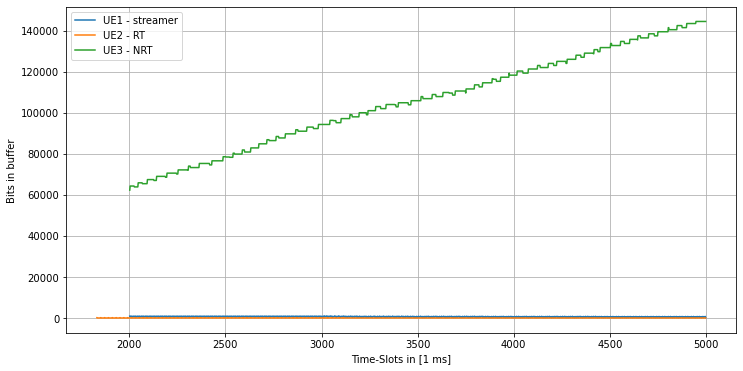

In [599]:
for i in np.arange(len(ue_comp)):
    if(ue_comp[i].qos==2):
        stream=i
    if(ue_comp[i].qos==1):    
        rt=i
    if(ue_comp[i].qos==0):
        nrt=i

plt.figure(figsize=(12,6))
plt.plot(list(ue_comp[stream].mon.keys())[1000:3000],list(ue_comp[stream].mon.values())[1000:3000],label='UE1 - streamer')
plt.plot(list(ue_comp[rt].mon.keys())[1000:3000],list(ue_comp[rt].mon.values())[1000:3000],label='UE2 - RT')
plt.plot(list(ue_comp[nrt].mon.keys())[1000:3000],list(ue_comp[nrt].mon.values())[1000:3000],label='UE3 - NRT')
#plt.plot(list(ue_list[120].mon.keys())[1000:3000],list(ue_list[120].mon.values())[1000:3000],label='UE4')
plt.xlabel('Time-Slots in [1 ms]')
plt.ylabel('Bits in buffer')
plt.legend(loc="upper left")
plt.grid()
#plt.axvline(x = 13, color = 'b', label = 'axvline - full height')
#plt.axvline(x = 27, color = 'b', label = 'axvline - full height')

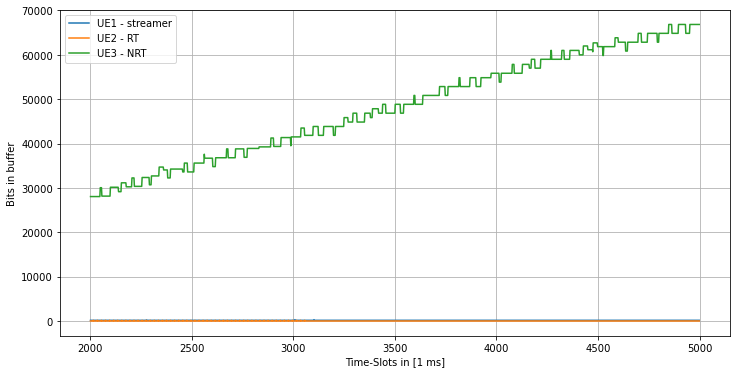

In [600]:
for i in np.arange(len(ue_list)):
    if(ue_list[i].qos==2):
        stream=i
    if(ue_list[i].qos==1):    
        rt=i
    if(ue_list[i].qos==0):
        nrt=i

plt.figure(figsize=(12,6))
plt.plot(list(ue_list[stream].mon.keys())[1000:3000],list(ue_list[stream].mon.values())[1000:3000],label='UE1 - streamer')
plt.plot(list(ue_list[rt].mon.keys())[1000:3000],list(ue_list[rt].mon.values())[1000:3000],label='UE2 - RT')
plt.plot(list(ue_list[nrt].mon.keys())[1000:3000],list(ue_list[nrt].mon.values())[1000:3000],label='UE3 - NRT')
#plt.plot(list(ue_list[120].mon.keys())[1000:3000],list(ue_list[120].mon.values())[1000:3000],label='UE4')
plt.xlabel('Time-Slots in [1 ms]')
plt.ylabel('Bits in buffer')
plt.legend(loc="upper left")
plt.grid()
#plt.axvline(x = 13, color = 'b', label = 'axvline - full height')
#plt.axvline(x = 27, color = 'b', label = 'axvline - full height')

In [601]:
ue_list=ue_dict[19]
for i in ue_list:
    print('User')
    print(i.bits)
    print(i.mR)
    print(i.bits2)
    print(i.mR2)
    print(i.comp)

User
196000.0
78.43137254901953
196000
39.00944131153864
0
User
101892.0
40.77310924369739
194974.0
40.529419290725556
0
User
194000.0
77.63105242096844
196000.0
39.27416504817217
0
User
102522.0
41.025210084033645
194804.0
40.253425740043866
0
User
194000.0
77.63105242096832
194000.0
38.70599540336336
0
User
114750.0
45.91836734693881
198000.0
38.88968952927305
0
User
178707.5
71.51160464185686
198000.0
39.0441510737948
0
User
115700.0
46.29851940776313
190000.0
37.87099473642997
0
User
56060.0
22.43297318927573
105460.0
21.955674626793527
0
User
76518.0
30.619447779111603
146718.0
30.413512824097225
0
User
178618.75
71.47609043617456
200000.0
39.815610718076705
0
User
116100.0
46.45858343337336
198000.0
39.845165757379334
0
User
196000.0
78.43137254901951
196000.0
38.736262812447855
0
User
102732.0
41.10924369747905
192000.0
39.16012695594437
0
User
200000.0
80.0320128051219
200000
39.706318701950785
0
User
66258.0
26.513805522208884
125514.0
26.03204258894435
0
User
145178.75
58.094

In [658]:
ue_list=ue_dict[19]

In [670]:
prb_number_normal

31

In [667]:
C=0
nC=0
for i in ue_all:
    print('C:', i.mR)
    print('nC:',i.mR2)
    print('C-queue:', i.queue.level)
    print('nC-queue:',i.queue2.level)
    print('nC-queue:',i.qos)
    nC=nC+i.mR2
    C=C+i.mR

C: 35.07009868802282
nC: 39.03703926388798
C-queue: 125117.5
nC-queue: 0.0
nC-queue: 0.0
C: 57.225004647581024
nC: 16.798610309660283
C-queue: 57520.0
nC-queue: 108070.0
nC-queue: 0.0
C: 79.7671272358436
nC: 38.74122080708045
C-queue: 0.0
nC-queue: 6385.0
nC-queue: 0.0
C: 76.83756750893917
nC: 23.109955370132734
C-queue: 0.0
nC-queue: 82534.0
nC-queue: 0.0
C: 12.194443933655828
nC: 16.75319858329999
C-queue: 164070.0
nC-queue: 112280.0
nC-queue: 0.0
C: 77.65680249451054
nC: 22.8955755835957
C-queue: 0.0
nC-queue: 85626.0
nC-queue: 0.0
C: 34.927769532789185
nC: 38.40974303782263
C-queue: 102425.0
nC-queue: 0.0
nC-queue: 0.0
C: 25.089946308886677
nC: 34.36956256805466
C-queue: 139000.0
nC-queue: 32300.0
nC-queue: 0.0
C: 35.16086101724678
nC: 39.20830318045936
C-queue: 105325.0
nC-queue: 0.0
nC-queue: 0.0
C: 12.184426937497426
nC: 16.785750119900268
C-queue: 168090.0
nC-queue: 116110.0
nC-queue: 0.0
C: 57.52019106621164
nC: 16.802867870676444
C-queue: 49108.75
nC-queue: 114050.0
nC-queue:

In [676]:
mean_tbs=0
for i in ue_all:
    mean_tbs+=i.tbs
    
mean_tbs=mean_tbs/len(ue_all)

mean_tbs2=0
ue_list=ue_dict[19]
for i in ue_list:
    mean_tbs2+=i.tbs
ue_list=ue_dict[20]
for i in ue_list:
    mean_tbs2+=i.tbs
    
mean_tbs2=mean_tbs2/(len(ue_dict[19])+len(ue_dict[20]))

In [680]:
print('all:',mean_tbs)
print('no comp:',mean_tbs2)

all: 50.69464285714286
no comp: 59.725


In [689]:
ue_all_19=ue_all[0:69]
av=0
for i in ue_all_19:
    av+=i.mR/i.mR2
av=av/70

In [690]:
av

1.5932362043365778